# Project: Northwind Product Discount Order-Effect Analysis

The top-level goal of this project is to answer the question:

    1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
    
Sub-goals are to additionall answer the following questions:

    2. Does discount amount have a statistically significant effect on INCREASING revenue? If so, at what level(s) of discount?
    3. Given that a customer has received a discount in the past, does that customer tend to place more orders than customers not receiving any discount?  If so, what discount rate induces the highest post-discount order rate?  Additionally, is the post-discount non-discounted order rate higher than the order-rate of customers never receiving a discount? (Note that this is really two questions wrapped into one.)
    
<br><br>

Our data set is the Northwind database - a free, open-source dataset created by Microsoft containing data from a fictional company.

<br>

## Approach

As is industry standard for Data Science project, I use the OSEMN model:

<p><br>
<img src="https://miro.medium.com/max/3870/1*eE8DP4biqtaIK3aIy1S2zA.png" width="800px">

## Import Libraries and init common globals

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, Markdown
import numpy as np
import scjpnlib.utils as scjpnutils
from scjpnlib.utils import sql_manager as sqlmgr
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set()

fs_default = (10,9)
plt_title_font_dict = {'fontsize' : 16}

pysqldfmgr = sqlmgr.PySQLDFManager(globals())

rand_state = np.random.seed(17)

c_disc = 'blue'
c_no_disc = 'saddlebrown'
c_reject_null = 'lime'
c_no_reject_null = 'red'

<p><br><br>

## Obtain the data

Luckily, the data has already been gathered for us and is in `Northwind_small.sqlite`, a sqlite database file.

The project is based on the data set in this database.

Normally from here we would move on to EDA and scrubbing the data.  But before doing so blindly, let's define the scope in order to focus on the goal of the project.

<br><br>

# QUESTION 1

## Define scope of analysis and build hypotheses
Again, the main goal of the project is to answer the question:

    Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

So let's formulate our initial hypotheses and determine what tables/columns are involved to that end.  If we can limit our scope up front, that should reduce the potential complexity involved in the traditional EDA and data-scrubbing phase.  But, in order to understand the scope involved, we need to have a clear understanding of our hypotheses.

The hypotheses are nearly generated for us in the problem statement.  We just need to formalize them mathematically.

Looking at the ERD will help us to better understand the details.

<img src="Northwind_ERD_updated.png">


One point of clarification is that a discount is applied to an entire order (when granted), not an individual product.  So we need to find the set of all unique products over all orders that have been discounted. In this manner, we can partition the data.

<p><br>

It is clear from the ERD above that we can restrict our scope to the **OrderDetail** table in order to answer the goal-question.

But, in order to provide an answer to our goal-question, we need to find a basis for comparison.  The basis is, of course, records in OrderDetail where Discount = 0 versus those where Discount > 0.  

So, we need to first construct the set of unique products over all orders that have had a discount applied.  Let's call this set of unique products appearing on orders that have had a discount applied, $D$.

Taking a microscopic view of the problem, given $D$, for each product, $p \in D$, label the mean quantity of that product ordered with and without a discount applied to orders in which product $p$ appears, thusly:

1. $\mu_p$ is the mean **Quantity** of product $p$ appearing on orders WITHOUT a discount
2. $\mu_p^*$ is the mean **Quantity** of product $p$ appearing on orders WITH a discount

Then, on a product-by-product basis, our null hypothesis is:

$H_0$: $\mu_p^* = \mu_p$.

And, again on a product-by-product basis, our alternate hypothesis is:

$H_a$: $\mu_p^* \ne \mu_p$.

But we want a cumulative idea of the effect of the discount, not on a product-by-product basis.

<p><br><br>
So, we redefine our hypotheses as follows:

1. let $\mu$ denote the mean **Quantity** of all product $p \in D$ appearing on orders WITHOUT a discount
2. let $\mu_d$ denote the mean **Quantity** of all product $p \in D$ appearing on orders WITH a discount

Then our null hypothesis is:

$H_0$: $\mu_d = \mu$.

And our alternate hypothesis is:

$H_a$: $\mu_d \ne \mu$.

<br>

$\alpha=0.05$

<br><br>

Our immediate goal is to get a set of OrderDetail records.  But the first thing we need to do is...

<p><br>

### Import data set from sqlite database file

In [2]:
# import the data set from sqlite database
nwsqlitedbmgr = sqlmgr.SQLiteDBManager('Northwind_small.sqlite')

Then...

<p><br>

### Load all tables in the scope into data frames for ease of manipulation and show high-level summary

In [3]:
# input: dict mapping sql table name to its corresponding data frame name
def summarize_scope(scope, init=False):
    display(Markdown(f"#### Scope Summary:<br>"))
    
    tables_with_nulls = []
    for tn, tbl_df in scope.items():
        if init and tbl_df is None:
            tbl_df = nwsqlitedbmgr.sql_query_to_df(f"SELECT * FROM [{tn}]")
            scope[tn] = tbl_df
            
        display(Markdown(f"Table <b>{tn}</b>:"))
        cols_with_nulls = scjpnutils.summarize_df(tbl_df)
        if len(cols_with_nulls) > 0:
            tables_with_nulls.append(tn)
        display(HTML(f"<p><br><br>"))

    if len(tables_with_nulls) > 0:
        display(HTML(f"<h3>Tables with null values:</h3>"))
        print(tables_with_nulls)
        
    return scope, tables_with_nulls

In [4]:
q1_scope = {'OrderDetail': None}
q1_scope, ql_scope_tables_with_nulls = summarize_scope(q1_scope, init=True)

#### Scope Summary:<br>

Table <b>OrderDetail</b>:

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2155 non-null   object 
 1   OrderId    2155 non-null   int64  
 2   ProductId  2155 non-null   int64  
 3   UnitPrice  2155 non-null   float64
 4   Quantity   2155 non-null   int64  
 5   Discount   2155 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


## Clean Null Values (if necessary)

In [5]:
def summarize_scope_tables_with_nulls(scope, tables_with_nulls):
    if len(tables_with_nulls) == 0:
        display(HTML("<b>No table in scope has any observations with null values.</b>"))
        return
    
    for nv_tn in tables_with_nulls:
        cwnv_df = scjpnutils.cols_with_nulls(scope[nv_tn])
        display(HTML(f"Columns with null values in table <b>{nv_tn}</b>:<br>"))
        scjpnutils.print_df(cwnv_df)
        display(HTML("<br><br>"))

In [6]:
summarize_scope_tables_with_nulls(q1_scope, ql_scope_tables_with_nulls)

Now we can move on to...

## Investigate and handle potential outlier values

A boxplot will give us a visual feel for any potential outliers of Quantity, grouped by Discount.

The mean Discount is also shown below.  This is done to highlight that its value will be affected by the presence of outliers (if any).

In [7]:
# this function simply wraps the functionality to display a boxplot of Quantity... to get a visual feel for observations with outliers
def boxplot_od_qty_outliers(od_df, prior_mean_qty=None):
    fig = plt.figure(figsize=fs_default)
    sns.boxplot(od_df.Discount, od_df.Quantity) # groups x-axis by unique vals
    mean_qty = od_df.Quantity.mean()
    if prior_mean_qty is None:
        plt.axhline(y=mean_qty, color="red", label=f"mean Quantity ({round(mean_qty,2)})")
    else:
        plt.axhline(y=prior_mean_qty, color="red", label=f"original mean Quantity ({round(prior_mean_qty,2)})")
        plt.axhline(y=mean_qty, color="blue", label=f"new mean Quantity ({round(mean_qty,2)})")
    plt.legend()
    plt.title("Quantity Value Outlier Analysis", fontdict=plt_title_font_dict)
    fig.tight_layout()
    plt.show();

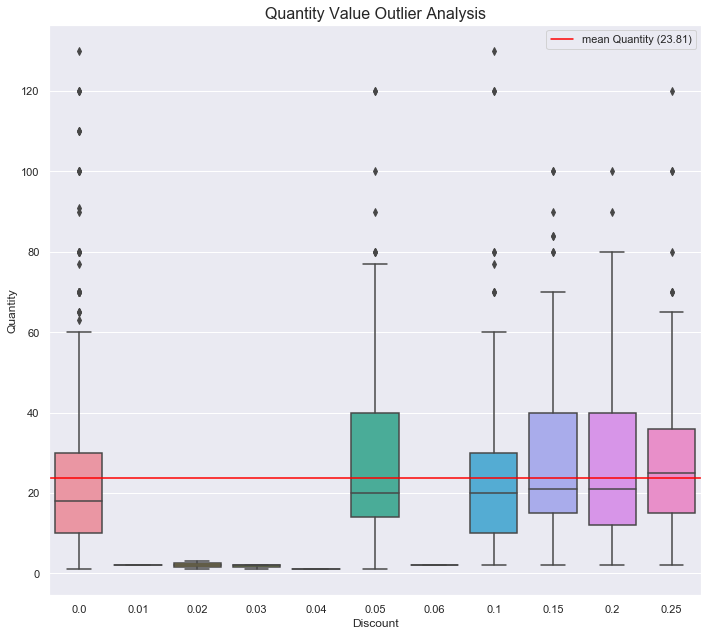

In [8]:
order_detail_df = q1_scope['OrderDetail']
boxplot_od_qty_outliers(order_detail_df)

old_mean_qty = order_detail_df.Quantity.mean()

There are a couple of things to note from the above.

1. We do see the presence of outliers (outside of the whiskers) in Discount bins \[0.0, 0.05, 0.1, 0.15, 0.2, 0.25\]; since they are "above" they will pull the mean Quantity "up".
2. The range of Quanities in the \[0.01, 0.02, 0.03, 0.04, 0.06\] Discount bins are nominal at best; they will pull the mean Quantity "down".

Our first sub-goal is to deal with the above in order to get a better measure of mean Quantity since our hypotheses depend on it.

First, we need to precisely identify outliers in each bin.

We can do this by utilizing the IQR of Quantity values for each binned Discount.

In [9]:
type_1_outlier_discount = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
type_2_outlier_discount = [0.01, 0.02, 0.03, 0.04, 0.06]

Let's drop "type 2" outliers first...

In [10]:
n_total_dropped = 0

order_detail_qty_outliers_removed_df = order_detail_df.copy()
for d_outlier in type_2_outlier_discount:
    len_before_drop = len(order_detail_qty_outliers_removed_df)
    df_outliers = order_detail_df.query(f"Discount=={d_outlier}")
    order_detail_qty_outliers_removed_df = order_detail_qty_outliers_removed_df.drop(df_outliers.index)
    len_after_drop = len(order_detail_qty_outliers_removed_df)
    n_dropped = len_before_drop - len_after_drop
    n_total_dropped += n_dropped
    print(f"dropped {n_dropped} records for Discount value {d_outlier}")
#print(f"\ndropped {n_total_dropped} total outlier observations (including outlier Quantities)")

dropped 1 records for Discount value 0.01
dropped 2 records for Discount value 0.02
dropped 3 records for Discount value 0.03
dropped 1 records for Discount value 0.04
dropped 1 records for Discount value 0.06


In [11]:
# find outlier values of Quantity based on its IQR for each Discount
def get_qty_outlier_vals_by_discount(s_order_detail_df_name, check_discounts=None):
    qty_outliers_for_discount = {}
    if check_discounts is None:
        df_distinct_discounts = pysqldfmgr.pysqldf(f"SELECT DISTINCT Discount FROM {s_order_detail_df_name} ORDER BY Discount ASC")
        check_discounts = list(df_distinct_discounts.Discount.unique())
    for d in check_discounts:
        # get the quantities for this discount and also sort ascending
        df_q = pysqldfmgr.pysqldf(f"SELECT ProductId, Quantity, Discount FROM {s_order_detail_df_name} WHERE Discount={d} ORDER BY Quantity ASC")
        
        q1, q3 = np.percentile(df_q.Quantity, [25, 75])
        delta = q3 - q1
        iqr_q_lb = q1 - (1.5 * delta) 
        iqr_q_ub = q3 + (1.5 * delta)

        df_q_outliers_for_d = pysqldfmgr.pysqldf(f"""
            SELECT ProductId, Quantity, Discount 
            FROM {s_order_detail_df_name} 
            WHERE Discount={d} AND (Quantity < {iqr_q_lb} OR Quantity > {iqr_q_ub})
        """)

        q_outliers_for_d = sorted(list(df_q_outliers_for_d.Quantity.unique()))
        display(HTML(f"Outlier values for <b>Quantity</b> (IQR lb: {iqr_q_lb}, IQR ub: {iqr_q_ub}) for discount={d}: {q_outliers_for_d}"))
        qty_outliers_for_discount[d] = q_outliers_for_d
    print()
    return qty_outliers_for_discount

# this function will handle a set of outlier values by passing in a callback
#    the specific manner in which outliers are handled is defined by the callback function
def handle_qty_outliers(order_detail_df, qty_outliers_for_discount, f_outliers_df_index_handler, kwargs=None):
    for d, q_outliers_for_d in qty_outliers_for_discount.items():
        for q_outlier in q_outliers_for_d:
            #find records with outlier qty value for this discount
            df_outliers = order_detail_df.query(f"(Discount=={d}) & (Quantity=={q_outlier})")
            order_detail_df = f_outliers_df_index_handler(order_detail_df, d, q_outlier, df_outliers.index, kwargs)
    return order_detail_df

# this handler is passed to handle_qty_outliers()
#   it will drop records from the index resulting from finding Quatity outliers in handle_qty_outliers()
def drop_index_handler(order_detail_df, d, q_outlier, df_outliers_index, kwargs):
    len_before_drop = len(order_detail_df)
    order_detail_df = order_detail_df.drop(df_outliers_index)
    len_after_drop = len(order_detail_df)
    n_dropped = len_before_drop - len_after_drop
    print(f"dropped {n_dropped} records for Discount value {d} with outlier Quantity value {q_outlier}")
    return order_detail_df

def drop_qty_outlier_vals_by_discount(s_od_df_name, lst_discounts_with_outliers=None, display_box_plot=True, original_mean=None):
    od_df = globals()[s_od_df_name]
    len_before = len(od_df)
    
    # now call handle_qty_outliers(), passing in drop_index_handler() to drop qualifying records
    #   the resulting DF is saved to a new DF
    od_qty_outliers_removed_df = handle_qty_outliers(
        od_df.copy()
        , get_qty_outlier_vals_by_discount(s_od_df_name, lst_discounts_with_outliers)
        , drop_index_handler
    )

    # print the results
    len_after = len(od_qty_outliers_removed_df)
    n_total_dropped = len_before - len_after
    print(f"\ndropped {n_total_dropped} total outlier observations")
    
    if display_box_plot:
        display(Markdown("<br>Now let's have a look at a new boxplot after removing outliers and compare the new mean Quantity to the old..."))
        boxplot_od_qty_outliers(od_qty_outliers_removed_df, original_mean if original_mean is not None else od_df.Quantity.mean())
    
    return (n_total_dropped, od_qty_outliers_removed_df)

Now remove "type 1" outliers...


dropped 1 records for Discount value 0.0 with outlier Quantity value 63
dropped 3 records for Discount value 0.0 with outlier Quantity value 65
dropped 10 records for Discount value 0.0 with outlier Quantity value 70
dropped 1 records for Discount value 0.0 with outlier Quantity value 77
dropped 6 records for Discount value 0.0 with outlier Quantity value 80
dropped 1 records for Discount value 0.0 with outlier Quantity value 90
dropped 1 records for Discount value 0.0 with outlier Quantity value 91
dropped 4 records for Discount value 0.0 with outlier Quantity value 100
dropped 3 records for Discount value 0.0 with outlier Quantity value 110
dropped 3 records for Discount value 0.0 with outlier Quantity value 120
dropped 1 records for Discount value 0.0 with outlier Quantity value 130
dropped 3 records for Discount value 0.05 with outlier Quantity value 80
dropped 1 records for Discount value 0.05 with outlier Quantity value 90
dropped 1 records for Discount value 0.05 with outlier Q

<br>Now let's have a look at a new boxplot after removing outliers and compare the new mean Quantity to the old...

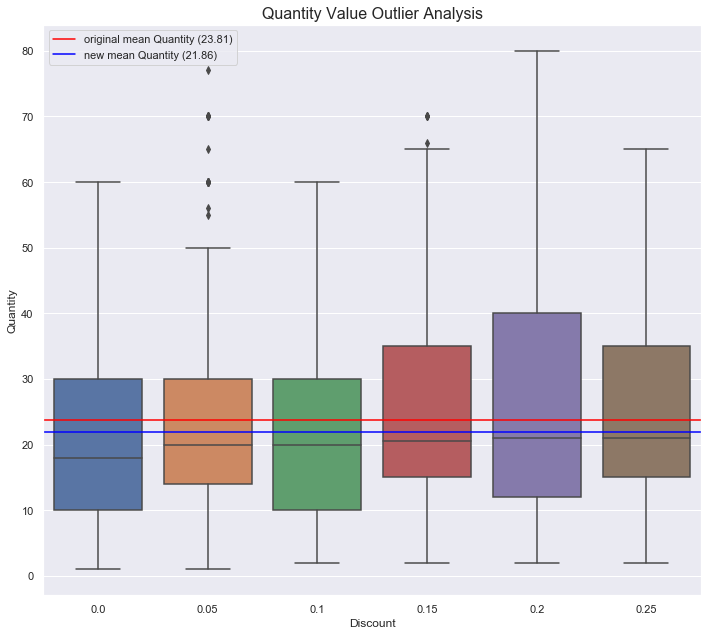

In [12]:
n_total_dropped, order_detail_qty_outliers_removed_df = drop_qty_outlier_vals_by_discount(
    'order_detail_qty_outliers_removed_df'
    , type_1_outlier_discount
    , display_box_plot=True
    , original_mean=old_mean_qty
)

It appears that addressing the former outliers was effective, as the mean has dropped by *roughly* by 10% of its former value.

But let's formalize this via ***Cohen's D***.

In [13]:
# borrowed directly from corresponding lesson on Learn
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

def Cohen_d_qual(cd):
    cd = abs(cd)
    if cd < 0.2:
        return "nominal"
    elif cd < 0.5:
        return "small"
    elif cd < 0.8:
        return "medium"
    else:
        return "large"

In [14]:
cd = Cohen_d(order_detail_df.Quantity, order_detail_qty_outliers_removed_df.Quantity)
print(f"{cd} ({Cohen_d_qual(cd)})")

0.11389943135244662 (nominal)


The effect size of removing outliers is small but not insignificant.

One thing to note from the above boxplot is that some (new) outliers appear for Discount = 0.05 and Discount = 0.15.

Let's determine if it's worth pursuing another round of outlier-cleanup...

In [15]:
type_1_outlier_discount = [0.05, 0.15]
qty_outliers_for_discount = get_qty_outlier_vals_by_discount('order_detail_qty_outliers_removed_df', type_1_outlier_discount)
d_kwargs = {'n_outliers_remaining':0}

def count_index_handler(order_detail_df, d, q_outlier, df_outliers_index, kwargs):
    n_records = len(order_detail_df.loc[df_outliers_index])
    print(f"there are {n_records} records with Quantity outlier value {q_outlier} for discount {d}")
    kwargs['n_outliers_remaining'] += n_records
    return order_detail_df

handle_qty_outliers(
    order_detail_qty_outliers_removed_df
    , qty_outliers_for_discount
    , count_index_handler
    , d_kwargs
)
print(f"\nthere are {d_kwargs['n_outliers_remaining']} total Quantity outlier records remaining out of {len(order_detail_qty_outliers_removed_df)} total records")


there are 1 records with Quantity outlier value 55 for discount 0.05
there are 1 records with Quantity outlier value 56 for discount 0.05
there are 9 records with Quantity outlier value 60 for discount 0.05
there are 1 records with Quantity outlier value 65 for discount 0.05
there are 6 records with Quantity outlier value 70 for discount 0.05
there are 1 records with Quantity outlier value 77 for discount 0.05
there are 1 records with Quantity outlier value 66 for discount 0.15
there are 4 records with Quantity outlier value 70 for discount 0.15

there are 24 total Quantity outlier records remaining out of 2081 total records


24/2081 doesn't seem worth the effort - we don't want to drop too many records.

Plus, it is possible that doing another round of IQR-outlier analysis will yield yet new outliers.

<br>

Let's summarize the results of our committed outlier-cleanup...

In [16]:
n_start = len(order_detail_df)
n_end = len(order_detail_qty_outliers_removed_df)
n_dropped = n_start - n_end

d_kwargs['n_outliers_remaining'] = 0
handle_qty_outliers(
    order_detail_qty_outliers_removed_df
    , get_qty_outlier_vals_by_discount('order_detail_qty_outliers_removed_df')
    , count_index_handler
    , d_kwargs
)

print(f"\ndropping {n_dropped} observations with outlier Quantity values from {n_start} starting observations yields an effect size of {cd} with {d_kwargs['n_outliers_remaining']}/{n_end} outliers remaining")


there are 1 records with Quantity outlier value 55 for discount 0.05
there are 1 records with Quantity outlier value 56 for discount 0.05
there are 9 records with Quantity outlier value 60 for discount 0.05
there are 1 records with Quantity outlier value 65 for discount 0.05
there are 6 records with Quantity outlier value 70 for discount 0.05
there are 1 records with Quantity outlier value 77 for discount 0.05
there are 1 records with Quantity outlier value 66 for discount 0.15
there are 4 records with Quantity outlier value 70 for discount 0.15

dropping 74 observations with outlier Quantity values from 2155 starting observations yields an effect size of 0.11389943135244662 with 24/2081 outliers remaining


This seems acceptable.

At this point, it looks like we have done all the work necessary in order to scrub **OrderDetail** data.

Let's move on...

<br><br>

## Partition data into subsets with Discount == 0 and Discount > 0 and consider only those products appearing on discounted orders

We want to compare apples to apples, here.

So, in addition to partitioning based on whether an order has a **Discount** or not, we will also consider only those non-discounted orders containing the same products as those appearing on discounted orders.

In [17]:
orders_with_discount_df = pysqldfmgr.pysqldf(f"SELECT * FROM order_detail_qty_outliers_removed_df WHERE Discount>0")
distinct_discounted_products_df = pysqldfmgr.pysqldf(f"SELECT DISTINCT ProductId FROM orders_with_discount_df")
orders_without_discount_df = pysqldfmgr.pysqldf(f"""
    SELECT * 
    FROM order_detail_qty_outliers_removed_df 
    WHERE Discount=0 AND ProductId IN (SELECT * FROM distinct_discounted_products_df)
""")

<br><br>

## Answer the first part of the goal-question: Test Hypotheses

We will execute our battery of hypothesis tests against the groups with and without discounts as a whole.

Each of these tests will operate on the mean Quantity.

In [18]:
mu_no_discount = orders_without_discount_df.Quantity.mean()
mu_discount = orders_with_discount_df.Quantity.mean()

display(Markdown(f"$\mu={round(mu_no_discount,2)}$"))
display(Markdown(f"$\mu_d={round(mu_discount,2)}$"))

$\mu=20.02$

$\mu_d=24.81$

Let's have a look at the distributions to get a visual feel for how they match up to the above.

In [19]:
# this function simply wraps displaying a comparision of Seaborn distplots, with formatting
#    it will additionally place the means of the samples
def dist_plot_comparison(s1, s2, label, color=[c_no_disc, c_disc], restricted_domain=None):
    a = 0.25
    fig = plt.figure(figsize=fs_default)
    sns.distplot(s1, hist_kws={'alpha':a}, color=color[0], label=label[0])
    mu_1 = s1.mean()
    plt.axvline(mu_1, color=color[0], ls="--", label=f"$\\mu={round(mu_1,2)}$ ({label[0]})")
    sns.distplot(s2, hist_kws={'alpha':a}, color=color[1], label=label[1])
    mu_2 = s2.mean()
    plt.axvline(mu_2, color=color[1], ls="-.", label=f"$\\mu={round(mu_2,2)}$ ({label[1]})")
    plt.legend()
    plt.title(f"Comparison of distributions: nobs({label[0]})={len(s1)}, nobs({label[1]})={len(s2)}")
    fig.tight_layout()
    if restricted_domain is not None:
        axes = plt.gca()
        axes.set_xlim(restricted_domain)
    plt.show();

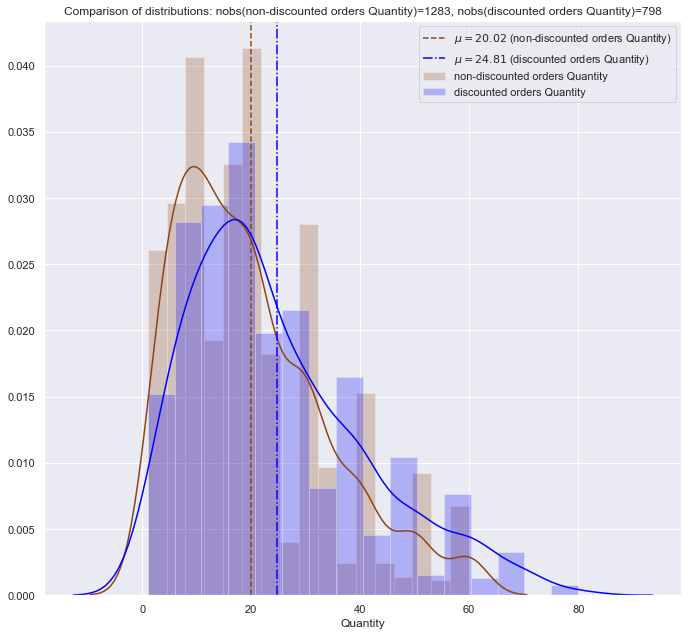

In [20]:
dist_plot_comparison(
    orders_without_discount_df.Quantity
    , orders_with_discount_df.Quantity
    , ["non-discounted orders Quantity", "discounted orders Quantity"]
)

Visually speaking, these distributions are clearly not normal.  

Additionally, we can see that **the distribution of Quantity values for products on discounted orders consistently trend to the right a bit more than they do for *the same products* on non-discounted orders**.

### Cohen's D: Measure the effect size of difference in means

In [21]:
cd_no_disc = Cohen_d(order_detail_qty_outliers_removed_df.Quantity, orders_without_discount_df.Quantity)
print(f"{cd_no_disc} ({Cohen_d_qual(cd_no_disc)})")
cd_disc = Cohen_d(order_detail_qty_outliers_removed_df.Quantity, orders_with_discount_df.Quantity)
print(f"{cd_disc} ({Cohen_d_qual(cd_disc)})")

0.12574236854279588 (nominal)
-0.19182887005380803 (nominal)


Since ***Cohen's D*** differs for each when compared to quantities of products orderered from all orders, this initially suggests that indeed $\mu_d \ne \mu$.

This ***Cohen's D*** measure seems to be inline with the observations we made visually above.

<br>

### Two-Sample T-Test: used to determine if the means of two samples of equal size and variance are equal

According to the `scipy.stats.ttest_ind` documentation:

    This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

Assumptions made when applying a Two-Sample T-Test:

1. Populations/samples are independent.
2. Sizes of samples are equal.
3. Variances of samples are equal.
4. Distributions are normal.

We would like to apply this test given that our two samples are indeed independent.

But as we saw above, the distributions clearly do not appear to be normal.

So, intution tells us that we cannot apply this test.

But, we want to be thorough, so let's check whether or not our samples *officially* meet the requirements to apply this test.

We'll test for normality first since we already have a visual feel for this result.

<br>

#### Normality Test

We will test this by running `scipy.stats.normaltest` on each partition.

**This test (the null hypothesis) assumes that the distribution is normal.**

Thus, if the p-value returned is greater than significance the level (0.05), the null hypothesis is rejected - i.e. the distribution is NOT normal.

In [22]:
def format_pval_result(p_val, alpha, kwargs, s_override=None):
    return "$p\\_val\\ ({}) {} \\alpha\\ ({}) \\implies$ {}".format(
        p_val
        , "<" if p_val < alpha else "\\ge"
        , alpha
        , s_override if s_override is not None else kwargs['positive_desc'] if p_val < alpha else kwargs['negative_desc']
    )

In [23]:
def normality_test(dist, alpha, s_base_desc="distribution"):
    sk, p_val = stats.normaltest(dist)
    display(Markdown(format_pval_result(p_val, alpha, {'positive_desc': f"{s_base_desc} is NOT normal", 'negative_desc': f"{s_base_desc} IS normal"})))
    return p_val >= alpha, p_val

In [24]:
alpha = 0.05

is_normal, p_val = normality_test(orders_without_discount_df.Quantity, alpha, "distribution of Quantity values for orders without discounts")
print(f"len(orders_without_discount_df.Quantity)={len(orders_without_discount_df.Quantity)}")
is_normal, p_val_d = normality_test(orders_with_discount_df.Quantity, alpha, "distribution of Quantity values for orders WITH discounts")
print(f"len(orders_with_discount_df.Quantity)={len(orders_with_discount_df.Quantity)}")

$p\_val\ (4.404118427297236e-32) < \alpha\ (0.05) \implies$ distribution of Quantity values for orders without discounts is NOT normal

len(orders_without_discount_df.Quantity)=1283


$p\_val\ (1.504198946335853e-19) < \alpha\ (0.05) \implies$ distribution of Quantity values for orders WITH discounts is NOT normal

len(orders_with_discount_df.Quantity)=798


Therefore, because the distributions of the samples are not normal and they are unequal in size, we cannot apply the <b><i>Two-sample T-Test</i></b>.

But, for the sake of completeness, let's check the other assumptions.

<br>

#### Equal-variance Test

Note that it would likely be naive simply to check for equality of `np.variance` since that does not consider allowing some small error.

Thus, we turn to `scipy.stats.levene` since, according to its documentation:

    The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test in the case where there are significant deviations from normality.
    
And, since we have indeed confirmed (above) that the distributions are not normal, Levene's test is appropriate.

**This test (the null hypothesis) assumes that the samples ARE from populations with equal variances.**

Just out of curiosity, let's first check using `np.variance`:

In [25]:
def equal_variance_test(s1, s2, alpha, s_base_desc="samples"):
    l_stat, p_val = stats.levene(s1, s2, center='mean') # h_null: equal variances
    display(Markdown(format_pval_result(p_val, alpha, {'positive_desc': f"{s_base_desc} are NOT from populations with equal variances", 'negative_desc': f"{s_base_desc} ARE from populations with equal variances"})))
    return p_val >= alpha, p_val

In [26]:
v_no_discount = np.var(orders_without_discount_df.Quantity)
print(f"The set of orders without a discount has variance: {v_no_discount}.")
v_discounted = np.var(orders_with_discount_df.Quantity)
print(f"The set of orders WITH a discount has variance: {v_discounted}.")

equal_var, p_val = equal_variance_test(orders_without_discount_df.Quantity, orders_with_discount_df.Quantity, alpha)

The set of orders without a discount has variance: 192.93108938824085.
The set of orders WITH a discount has variance: 265.5494076670373.


$p\_val\ (3.857175332125944e-07) < \alpha\ (0.05) \implies$ samples are NOT from populations with equal variances

Therefore, because the samples are NOT from populations with equal variances, we cannot apply the <b><i>Two-sample T-Test</i></b>.

<br><br>

### Welch's Test: used to determine if two sample means with unequal variance are equal

We can pass `equal_var=False` to `scipy.stats.ttest_ind` to perform ***Welch's Test***.

According to the documentation:

    If [equal_var=]False, perform Welch’s t-test, which does not assume equal population variance.
    
As we have seen above, the samples are not from populations with equal variances.

Therefore, it is appropriate to apply ***Welch's Test*** in this case.

**This test (the null hypothesis) assumes that the sample means are equal.**

In [27]:
#   pay attention to dof since welch requires using welch_dof() below
def compute_t_crit(alpha, dof, is_one_tailed):
    t_crit = stats.t.ppf(1-(alpha if is_one_tailed else alpha/2), dof)
    return t_crit

def var(s):   
    return sum((s-s.mean())**2)/(len(s)-1)

def welch_dof(s1, s2):
    var_s1 = var(s1)
    len_s1 = len(s1)
    var_s2 = var(s2)
    len_s2 = len(s2)
    return (((var_s1/len_s1)+(var_s2/len_s2))**2)/((var_s1**2/(len_s1**2*(len_s1-1)))+(var_s2**2/(len_s2**2*(len_s2-1))))

def pooled_variance(s1, s2, is_welch=False):
    n1 = len(s1)
    n2 = len(s2)
    dof = (n1+n2-2) if not is_welch else welch_dof(s1,s2)
    return ((n1-1)*var(s1)+(n2-1)*var(s2))/dof

# manual computation of 2-sample t-test (not using scipy)... for comparison
# one_sided_type: None for two-sided, 'greater' for one-sided with for h_a: mu_s1 > mu_s2
#    for now, only support 'greater' for one-sided with for h_a: mu_s1 > mu_s2; switch around s1 and s2 if you need to test mu_s2 > mu_s1
def ttest_2samp(s1, s2, is_welch=False, one_tailed_type=None):
    if one_tailed_type is not None and one_tailed_type != 'greater':
        print(f"'{one_tailed_type}' is invalid one_sided_type; acceptable types are None (for two-tailed) or 'greater' for one-tailed")
        return
    
    dof = len(s1)+len(s2)-2 if not is_welch else welch_dof(s1,s2)
    #print(f"dof={dof}")
    
    if not is_welch:
        t_stat = (s1.mean()-s2.mean())/np.sqrt(pooled_variance(s1,s2)*((1/len(s1))+(1/len(s2))))
    else:
        t_stat = (s1.mean()-s2.mean())/np.sqrt((var(s1)/len(s1))+(var(s2)/len(s2)))
        
    if one_tailed_type is not None:
        p_val = 1 - stats.t.cdf(t_stat, dof)
    else:
        p_val = (1 - stats.t.cdf(abs(t_stat), dof)) * 2
        
    return (t_stat, p_val)

def visualize_t(t_stat, alpha, s1, s2, is_welch=False, one_tailed_type=None):
    if one_tailed_type is not None and one_tailed_type != 'greater':
        print(f"'{one_tailed_type}' is invalid one_sided_type; acceptable types are None (for two-tailed) or 'greater' for one-tailed")
        return
        
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=fs_default)
    ax = fig.gca()
    
    dof = len(s1)+len(s2)-2 if not is_welch else welch_dof(s1,s2)
    t_crit = compute_t_crit(alpha, dof, one_tailed_type is not None)  
    
    # cover range from -4 std dev. to + 4 std. dev. but extend to cover floor[t_stat]+1 if necessary
    xs = np.linspace(-max(int(abs(t_stat)+1),4), max(int(abs(t_stat)+1),4), 400)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    # the second argument is the degrees of freedom, which should be computed beforehand and
    # passed into this functin - take care to account for welch since dof in that case is not 
    # computed simply by summing lengths of the two samples and subtracting two; see welch_dof() above
    ys = stats.t.pdf(xs, dof, loc=0, scale=1)

    ax.plot(xs, ys, linewidth=3, color='darkblue')
    
    #fill everything as an accept (null-hyp) region until we define reject (null-hyp) regions below
    plt.fill_between(xs, ys ,0, color=c_no_reject_null)

    if one_tailed_type is None:
        ax.axvline(-t_crit, color=c_no_reject_null, linestyle='--', lw=4, label="critical t-value: $" + f"{round(-t_crit,2)}" + "$")
        ax.fill_betweenx(ys, xs, -t_crit, color=c_reject_null, where=xs < -t_crit)
    ax.axvline(t_crit, color='red', linestyle='--', lw=4, label="critical t-value: $" + f"{round(t_crit,2)}" + "$")
    ax.fill_betweenx(ys, xs, t_crit, color=c_reject_null, where=xs > t_crit)

    # plot a vertical line for our measured t-statistic
    ax.axvline(t_stat, color='black', linestyle='--', lw=5, label=f"t-statistic: {round(t_stat,2)}")
    
    plt.legend()
    plt.title(
        f"{'One-tailed' if one_tailed_type is not None else 'Two-tailed'} Two-sample {'Welch ' if is_welch else ''}T-Test Visualization: Signficance $\\alpha={alpha}$"
        , fontdict=plt_title_font_dict
    )
    
    fig.tight_layout()
    plt.show()
    
def compute_conf_int(s, alpha, is_one_tailed=False):
    n = len(s)
    s_sd = s.std()    # Get the sample standard deviation
    s_mu = s.mean()
    sigma = s_sd/np.sqrt(n)
    dof = n - 1
#     t_crit = compute_t_crit(alpha, dof, is_one_tailed) # this function calculates conf. level interally; therefore, do not adjust alpha as in below sanity check!
#     moe = t_crit * sigma
#     ci = (s_mu - moe, s_mu + moe)
    
    # sanity check using scipy - use this instead for accuracy
    conf_lvl_adj = 1 - (alpha if is_one_tailed else alpha/2) # specifically for scipy t.interval() call
    ci2 = stats.t.interval(
        alpha = conf_lvl_adj    # Confidence level
        , df = dof              # Degrees of freedom
        , loc = s_mu            # Sample mean
        , scale = sigma         # Standard deviation estimate
    )
    moe2 = ci2[1]-s_mu
    
    return (
        s_mu
        , moe2
        , ci2
    )
        
def compute_delta_means_conf_int(s1, s2, alpha, is_welch=False, one_tailed_type=None):
    is_one_tailed = one_tailed_type is not None
    
    n1 = len(s1)
    mu1 = s1.mean()
    
    n2 = len(s2)
    mu2 = s2.mean()
    
    dof = n1+n2-2 if not is_welch else welch_dof(s1,s2)
    #for non-welch, we have: ((1/n1) + (1/n2)) <--> (n2 + n1)/(n1*n2)
    #for welch, let n1==n2==welch_dof+1 --> 2*(welch_dof+1)/(welch_dof+1)**2==2/(welch_dof+1)
    sigma = np.sqrt(pooled_variance(s1, s2, is_welch)) * (np.sqrt(1/n1 + 1/n2) if not is_welch else np.sqrt(2/(dof+1)))                                                  
    moe = compute_t_crit(alpha, dof, is_one_tailed) * sigma
                      
    delta_mu1_mu2 = mu1 - mu2
    ci = (delta_mu1_mu2 - moe, delta_mu1_mu2+moe)
    display(Markdown(f"{(1-alpha)*100}% confidence $\\Delta \\mu$ is in interval: ({round(ci[0],3)}, {round(ci[1],3)})"))
    
    deltas = (np.min(np.abs(ci)), np.max(np.abs(ci)))
    v_mid = (mu1+mu2)/2
    no_reject_delta_ub = v_mid+deltas[0]/2
    no_reject_delta_lb = v_mid-deltas[0]/2
    reject_delta_ub = v_mid+deltas[1]/2
    reject_delta_lb = v_mid-deltas[1]/2
    mu1_pass = mu1 > no_reject_delta_ub and mu1 <= reject_delta_ub
    display(Markdown(f"$\\mu_1={round(mu1,3)}$ in rejection region $({round(no_reject_delta_ub,3)}, {round(reject_delta_ub,3)}]$: {mu1_pass}"))
    mu2_pass = mu2 < no_reject_delta_lb and mu2 >= reject_delta_lb
    display(Markdown(f"$\\mu_2={round(mu2,3)}$ in rejection region $[{round(reject_delta_lb,3)}, {round(no_reject_delta_lb,3)})$: {mu2_pass}"))
    reject_null = mu1_pass and mu2_pass

    return (reject_null, ci, deltas)
    
def visualize_conf_int(s1, s2, alpha, is_welch, one_tailed_type, xlabels, ylabel, include_data=False):
    is_one_tailed = one_tailed_type is not None
    
    n1 = len(s1)
    mu1, moe1, ci1 = compute_conf_int(s1, alpha, is_one_tailed=is_one_tailed)
    
    n2 = len(s2)
    mu2, moe2, ci2 = compute_conf_int(s2, alpha, is_one_tailed=is_one_tailed)
    
    fig = plt.figure(figsize=fs_default)
    lw = 4
    
    pos_1 = 1
    pos_2 = 3
    
    # get delta means conf interval first and plot regions (reject/cannot reject)
    reject_null, ci_delta_means, deltas = compute_delta_means_conf_int(s1, s2, alpha, is_welch=is_welch, one_tailed_type=one_tailed_type)
    v_mid = (mu1+mu2)/2
    min_delta_ub = v_mid+deltas[0]/2
    min_delta_lb = v_mid-deltas[0]/2
    max_delta_ub = v_mid+deltas[1]/2
    max_delta_lb = v_mid-deltas[1]/2
    
    #reject null-hyp region
    cr = c_reject_null
    cra = 1
    plt.axhline(max_delta_ub, color=cr, linestyle="--", alpha=cra)
    plt.axhline(max_delta_lb, color=cr, linestyle="--", alpha=cra)
    plt.fill_between([i for i in range(pos_2+2)], max_delta_ub, min_delta_ub, color=cr, alpha=cra)
    plt.fill_between([i for i in range(pos_2+2)], min_delta_lb, max_delta_lb, color=cr, alpha=cra)
    
    #cannot reject null-hyp region
    cnr = c_no_reject_null
    cnra = cra
    plt.axhline(min_delta_ub, color=cnr, linestyle="--")
    plt.axhline(min_delta_lb, color=cnr, linestyle="--")
    plt.fill_between([i for i in range(pos_2+2)], min_delta_ub, min_delta_lb, color=cnr, alpha=cnra)
    
    #s1 plots
    c1 = c_disc
    c1da=0.2
    c1a = 0.75
    if include_data:
        plt.plot([pos_1 for i in range(len(s1))], s1, alpha=c1da, color=c1, marker='x', linestyle="None")
    plt.plot([pos_1], [mu1], marker='o', markersize=15, alpha=c1a, color=c1, label=f"{xlabels[0]} ($n={n1},\\mu={round(mu1,3)} \\pm {round(moe1,3)} (moe)$)")
    plt.bar([pos_1], [mu1], color=c1, alpha=c1a)
    plt.errorbar([pos_1], [mu1], yerr=[moe1], alpha=1, color='black', linestyle=":", linewidth=lw, capsize=10)
    
    #s2 plots
    c2 = c_no_disc
    c2da = c1da
    c2a = c1a
    if include_data:
        plt.plot([pos_2 for i in range(len(s2))], s2, alpha=c2da, color=c2, marker='x', linestyle="None")
    plt.plot([pos_2], [mu2], marker='o', markersize=15, alpha=c2a, color=c2, label=f"{xlabels[1]} ($n={n2},\\mu={round(mu2,3)} \\pm {round(moe2,3)} (moe)$)")
    plt.bar([pos_2], [mu2], color=c2, alpha=c2a)
    plt.errorbar([pos_2], [mu2], yerr=[moe2], alpha=1, color='black', linestyle=":", linewidth=lw, capsize=10)
    
    #labels and such
    plt.xlabel('samples')
    plt.ylabel(ylabel)
    plt.title(f"$\\Delta \\mu$ for Samples", fontdict=plt_title_font_dict)
    plt.xticks(range(5), [None, f"{xlabels[0]}", None, f"{xlabels[1]}", None])
    
    plt.legend()
    fig.tight_layout()
    
    plt.show();

    
# the actual t-test function wrapper we use
# one_sided_type: None for two-sided, 'greater' for one-sided with for h_a: mu_s1 > mu_s2
#    for now, only support 'greater' for one-sided with for h_a: mu_s1 > mu_s2; switch around s1 and s2 if you need to test mu_s2 > mu_s1
def t_test_2_samp(s1, s2, alpha, xlabels, ylabel, is_welch=False, one_tailed_type=None):
    if one_tailed_type is not None and one_tailed_type != 'greater':
        print(f"'{one_tailed_type}' is invalid one_sided_type; acceptable types are None (for two-tailed) or 'greater' for one-tailed")
        return

    t_stat, p_val = stats.ttest_ind(s1, s2, equal_var=not is_welch)
    p_val = p_val/2 if one_tailed_type=='greater' else p_val
    
    #validate manually
#     t_stat_manual, p_val_manual = ttest_2samp(s1, s2, is_welch=is_welch, one_tailed_type=one_tailed_type)
#     print(f"(t_stat, p_val)={(t_stat, p_val)} and (t_stat_manual, p_val_manual)={(t_stat_manual, p_val_manual)}")
    
    visualize_t(t_stat, alpha, s1, s2, is_welch=is_welch, one_tailed_type=one_tailed_type)
    
    display(Markdown("<p><br>"))
    visualize_conf_int(s1, s2, alpha, is_welch=is_welch, one_tailed_type=one_tailed_type, xlabels=xlabels, ylabel=ylabel, include_data=True)

    return (
        t_stat > 0 and p_val < alpha if one_tailed_type=='greater' else p_val >= alpha # for two-tailed assumption (h_0) is equal means; for one-tailed h_0 is mu_s1 <= mu_s2
        , p_val
    )

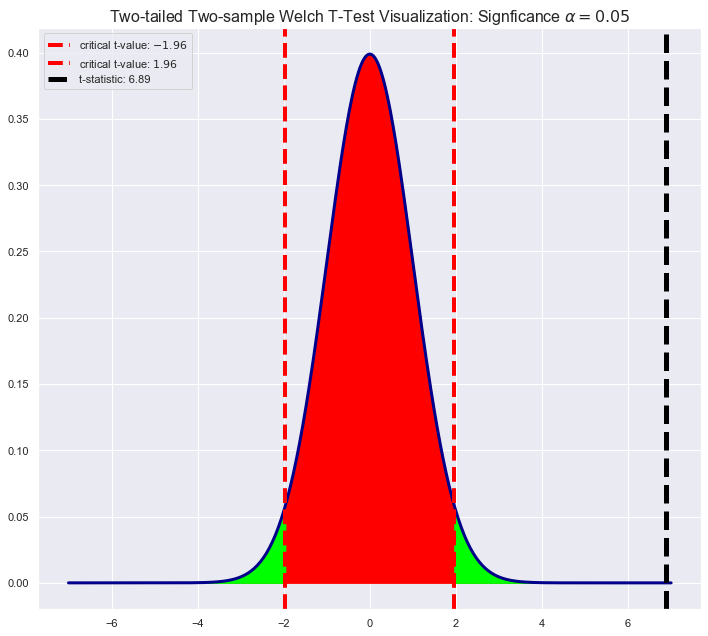

<p><br>

95.0% confidence $\Delta \mu$ is in interval: (3.532, 6.054)

$\mu_1=24.811$ in rejection region $(24.18, 25.441]$: True

$\mu_2=20.018$ in rejection region $[19.387, 20.648)$: True

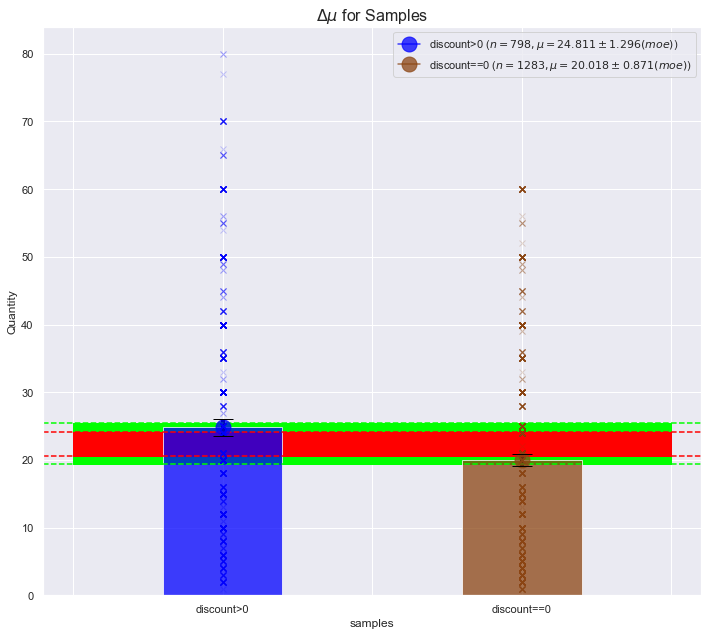

$p\_val\ (8.119991982163611e-12) < \alpha\ (0.05) \implies$ $\mu_d \ne\mu$.

In [28]:
equal_means, p_val = t_test_2_samp(
    orders_with_discount_df.Quantity
    , orders_without_discount_df.Quantity
    , alpha
    , xlabels=['discount>0', 'discount==0']
    , ylabel='Quantity'
    , is_welch=True
)
display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override="$\\mu_d " + ("=" if equal_means else "\\ne") + "\\mu$.")))

Thus, with ***Welch's Test***, the null hypothesis is rejected and the alternate hypothesis is accepted.

That is, the hypothesis that **discount amount DOES have a statistically significant effect on the quantity of a product ordered** is accepted.

But how can we say that this result applies outside of this data set?

*We can use resampling to run a Monte Carlo simulation on an arbitrary (large) number of simulations.*

<br><br>
### Monte Carlo Simulation Test: Rule out bias by resampling from the population and parameterizing the trial count

According to the "MC.test: Monte Carlo hypothesis testing for two samples. in asbio: A Collection of Statistical Tools for Biologists" article:

    Upper and lower tailed tests are performed by finding the portion of the distribution greater than or equal to the observed t test statistic (upper-tailed) or less than or equal to the observed test statistic (lower-tailed). A two tailed test is performed by multiplying the portion of the null distribution above the absolute value of the observed test statistic by two. ("MC.test: Monte Carlo hypothesis testing for two samples. in asbio: A Collection of Statistical Tools for Biologists", 2020)
    
**This test (the null hypothesis) assumes that the means of the samples are equal.**

In [29]:
# Monte Carlo simulation is used to test h_0: mu_test_sample == mu_null_sample (h_a: mu_test_sample != mu_null_sample)
def monte_carlo_test(null_sample, test_sample, n, with_replacement=False):
    U = pd.Series(np.concatenate((null_sample, test_sample)))
    delta_mu_threshold = np.mean(test_sample) - np.mean(null_sample)
    
    n_reject = 0
    p_vals = []
    for i in range(n):
        #ns_rs = pd.Series(np.random.choice(U, size=len(null_sample), replace=with_replacement))
        ns_rs = U.sample(len(null_sample), replace=with_replacement) #retains proper indexing in ns_rs
        mu_ns_rs = ns_rs.mean()
        ts_rs = U.drop(ns_rs.index)
        mu_ts_rs = ts_rs.mean()        
        n_reject += 1 if (ts_rs.mean() - ns_rs.mean()) >= delta_mu_threshold else 0   # accum null-hyp reject
        p_val = min(1,(n_reject/(i+1))*2) # since "A two tailed test is performed by multiplying the portion of the null distribution above the absolute value of the observed test statistic by two"
        p_vals.append(p_val)
    
    fig = plt.figure(figsize=fs_default)
    plt.plot(list(range(n)), p_vals, label=f"p_val convergence: {n_reject}/{i+1} = {p_val}")
    plt.xlabel(f"number of trials simulating permutation space")
    plt.ylabel("p-value")
    plt.legend()
    plt.title(f"Monte Carlo Simuation{' (with replacement)' if with_replacement else ''}: $\\Delta \\mu={delta_mu_threshold}, n={n}$", fontdict=plt_title_font_dict)
    fig.tight_layout()
    plt.show();
    
    display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override="$\\mu_t " + ("\\ne" if p_val < alpha else "=") + "\\mu_{null}$.<br><br>")))
    
    return p_val

<br>

#### Run the Monte Carlo Simulation Test

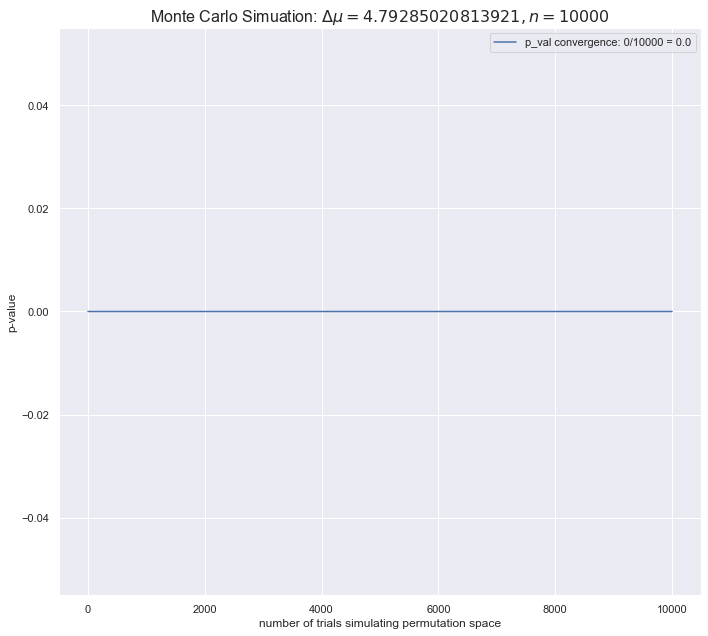

$p\_val\ (0.0) < \alpha\ (0.05) \implies$ $\mu_t \ne\mu_{null}$.<br><br>

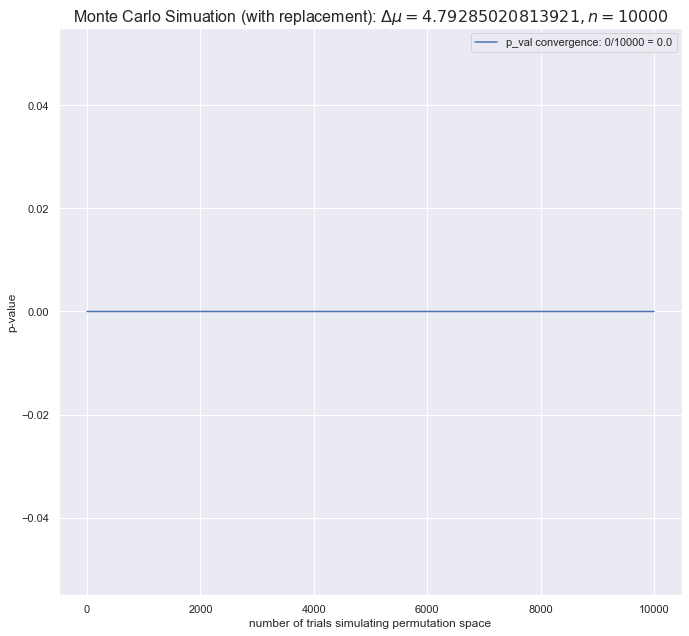

$p\_val\ (0.0) < \alpha\ (0.05) \implies$ $\mu_t \ne\mu_{null}$.<br><br>

In [30]:
n_simulations = 10000

p_val = monte_carlo_test(
    orders_without_discount_df.Quantity
    , orders_with_discount_df.Quantity
    , n_simulations
)

p_val_with_replacement = monte_carlo_test(
    orders_without_discount_df.Quantity
    , orders_with_discount_df.Quantity
    , n_simulations
    , with_replacement=True
)

We see that running Monte Carlo resampling simulations over 10000 trials results in a p-value of 0.0 in both with and without replacement.

These results seem rather dull (and that's probably a good thing) given that neither case produced a single rejection - i.e. no resampliong produced a $\Delta$mean $\ge$ the $\Delta$ mean threshold.

<br>

With this result, we have concluded our hypothesis tests and have therefore answered the first part of our goal-question. 

$H_0$ is rejected and the alternate hypothesis, $H_a$: **discounts DO have a statistically significant effect on the quantity of a product ordered**, is accepted.

In [31]:
display(Markdown(f"**On average, a customer given a discount orders {round(mu_discount/mu_no_discount,2)} times as many products as a non-discounted customer.**"))

**On average, a customer given a discount orders 1.24 times as many products as a non-discounted customer.**

<br>

Now let's move on to answer the second part:

    If so, at what level(s) of discount?

<br><br>

## Answer the second part of the goal-question

From the last section, we saw that, indeed, **discount amount DOES have a statistically significant effect on the quantity of a product ordered**.

In this section, **we want to determine which discount rates, if any, are more effective than the other**.  

In effect, we want to compare the mean **Quantity** values amongst the various **Discount** rates to one another and ask if there is any significant difference.  

This screams for using **ANOVA**.

At the time of this writing, the statsmodels documentation server was actually offline!  So I cannot currently cite the documentation for `sm.stats.anova_lm`.

I will, however, cite the description of what it accomplishes from a high-level:

    ANOVA tests if there is a difference in the mean somewhere in the model (testing if there was an overall effect), but it does not tell one where the difference is if the there is one. To find out where the difference is between the groups, one has to conduct post-hoc tests. ("Analysis of Variance (ANOVA)", 2019)

So, in an attempt to short-circuit the effort, let's run an **ANOVA** on `orders_with_discount_df.Quantity` vs. `orders_with_discount_df.Discount` to see if it reports any differences in means between **Discount** rates.

**ANOVA (the null hypothesis) assumes there is no difference in means amongst categories.**

In [32]:
f = "Quantity ~ C(Discount)"
lm = ols(f, orders_with_discount_df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),2141.323952,4.0,2.023756,0.089257
Residual,209767.103367,793.0,NaN,NaN


The p-value, as we see, is 0.089257 $\ge$ 0.05, which means that we cannot reject the null hypothesis - i.e. there is no statistically significant difference in mean **Quantity** as a function of **Discount** for those orders with a discount > 0.

This seems a bit counter-intuitive.

Let's dig a little deeper, shall we?

In [33]:
def summarize_mean_quantity_by_discount(od_df, sort=False):
    display(Markdown("#### Summary of Mean Quantity values grouped by Discount"))
    grouped_by_disc = od_df.Quantity.groupby(od_df.Discount)
    scjpnutils.print_df(grouped_by_disc.describe(), n=None, tail=False, show_count=False)
    
    fig = plt.figure(figsize=fs_default)
    grouped_means = grouped_by_disc.mean().sort_values(ascending=False).reset_index() if sort else grouped_by_disc.mean().reset_index()
    ax = sns.barplot(grouped_means.index, grouped_means.Quantity, data=grouped_means)
    ax.set_xticklabels(grouped_means.Discount)
    plt.ylabel("Mean Quantity")
    plt.xlabel("Discount")
    for index, row in grouped_means.iterrows():
        ax.text(index, row.Quantity, round(row.Quantity, 2), color='black', ha="center")
    fig.tight_layout()
    plt.show();

#### Summary of Mean Quantity values grouped by Discount

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.05,178.0,25.348315,17.669663,1.0,14.0,20.0,30.0,77.0
0.10,164.0,21.640244,13.892615,2.0,10.0,20.0,30.0,60.0
0.15,150.0,25.586667,16.699149,2.0,15.0,20.5,35.0,70.0
0.20,159.0,26.169811,17.309618,2.0,12.0,21.0,40.0,80.0
0.25,147.0,25.435374,15.294850,2.0,15.0,21.0,35.0,65.0


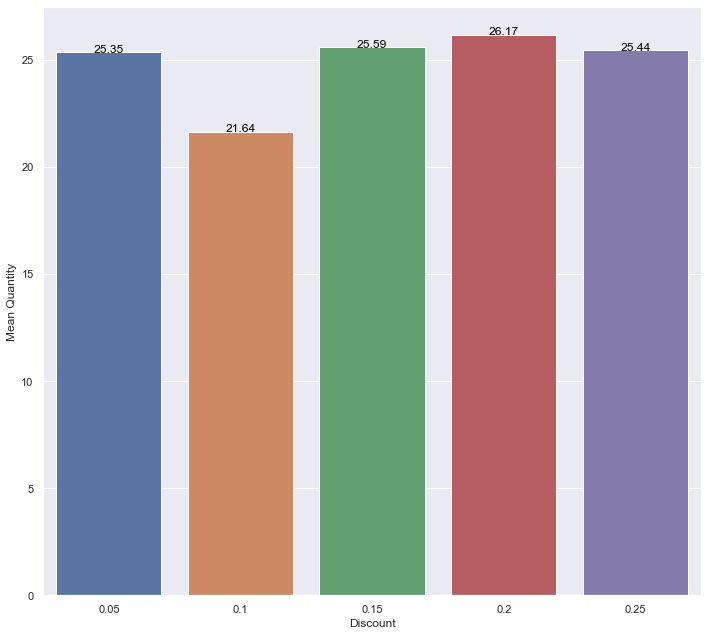

In [34]:
summarize_mean_quantity_by_discount(orders_with_discount_df)

Above, we see that the difference in means does not seem to vary much, with the exception of a 10% discount.

Additionally, 

    does a mean Quantity on orders with a 5% discount being relatively higher than orders with a 10% discount or, what's more, relatively equal to that of orders with a 25% discount make sense?!

I don't think so.  

Since a 25% discount compared to a 5% discount seems substantial, we would intuitively think that mean **Quantity** for the latter is substantially more.

A thought runs through my mind:

    is it possible that the remaining outliers are throwing this off?

Let's quickly run another round or two of outlier-cleanup, followed by another **ANOVA**.

In [35]:
# lst_discounts_with_outliers=None, display_box_plot=True, original_mean=None
# let's go for broke and continue to remove all outliers until none remain, but let's cap it at 3 iterations.  Let's not get ridiculous, here.
max_rounds = 3
n_round = 0
n_total_dropped = 0
order_detail_qty_outliers_removed_df_2 = order_detail_qty_outliers_removed_df.copy()
while n_round < max_rounds:
    n_round += 1
    n_dropped, order_detail_qty_outliers_removed_df_2 = drop_qty_outlier_vals_by_discount(
        'order_detail_qty_outliers_removed_df_2'
        , lst_discounts_with_outliers=None
        , display_box_plot=False
        , original_mean=None
    )
    print()
    n_total_dropped += n_dropped
    if n_dropped==0:
        n_round -= 1
        break
    
display(Markdown(f"Ran {n_round} rounds of additional outlier-cleanup{'; dropped an additional ' + str(n_total_dropped) + ' recods' if n_total_dropped > 0 else ''}<br><br>"))

orders_with_discount_df_2 = order_detail_qty_outliers_removed_df_2.query("Discount > 0")
orders_without_discount_df_2 = order_detail_qty_outliers_removed_df_2.query("Discount == 0")
f = "Quantity ~ C(Discount)"
lm = ols(f, orders_with_discount_df_2).fit()
sm.stats.anova_lm(lm, typ=2)


dropped 1 records for Discount value 0.05 with outlier Quantity value 55
dropped 1 records for Discount value 0.05 with outlier Quantity value 56
dropped 9 records for Discount value 0.05 with outlier Quantity value 60
dropped 1 records for Discount value 0.05 with outlier Quantity value 65
dropped 6 records for Discount value 0.05 with outlier Quantity value 70
dropped 1 records for Discount value 0.05 with outlier Quantity value 77
dropped 1 records for Discount value 0.15 with outlier Quantity value 66
dropped 4 records for Discount value 0.15 with outlier Quantity value 70

dropped 24 total outlier observations




dropped 10 records for Discount value 0.05 with outlier Quantity value 50

dropped 10 total outlier observations





dropped 0 total outlier observations



Ran 2 rounds of additional outlier-cleanup; dropped an additional 34 recods<br><br>

,sum_sq,df,F,PR(>F)
C(Discount),5552.597639,4.0,6.643477,0.000029
Residual,158592.459952,759.0,NaN,NaN


Aha!

Now ***ANOVA*** reports a lower p-value.

It appears those outliers did indeed make a difference!

After cleaning remaining outliers, ***ANOVA*** reports p-value, as we see, 0.000029 < 0.05, which means that **we CAN reject the null hypothesis** - i.e. **there IS a statistically significant difference in mean *Quantity* as a function of *Discount* for those orders with a discount > 0**.

But how much of a difference?

Let's have a look at the new mean **Quantity** values (by **Discount**) reported...

#### Summary of Mean Quantity values grouped by Discount

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.05,149.0,18.785235,9.704808,1.0,12.0,18.0,24.0,42.0
0.10,164.0,21.640244,13.892615,2.0,10.0,20.0,30.0,60.0
0.15,145.0,24.082759,14.836846,2.0,13.0,20.0,35.0,65.0
0.20,159.0,26.169811,17.309618,2.0,12.0,21.0,40.0,80.0
0.25,147.0,25.435374,15.294850,2.0,15.0,21.0,35.0,65.0


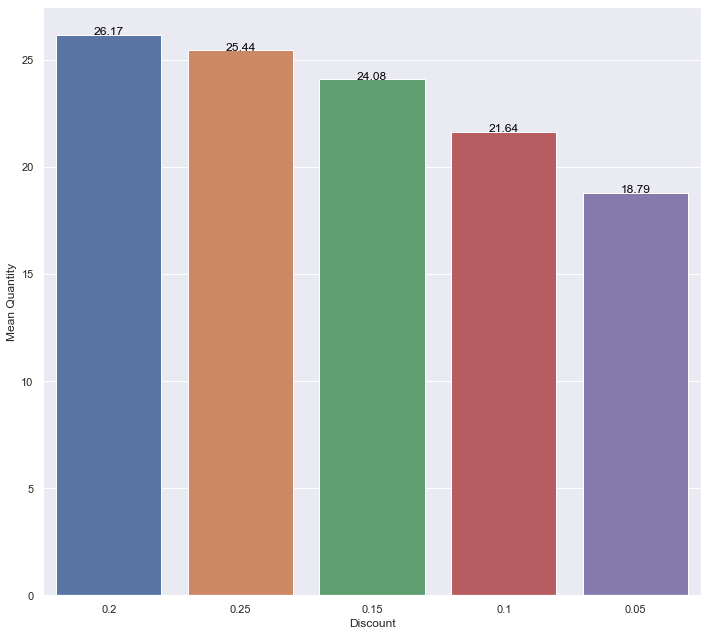

In [36]:
summarize_mean_quantity_by_discount(orders_with_discount_df_2, sort=True)

Now the above seems to mostly match intuition.

Those outliers did indeed make fairly significant differences.

Let's now include the mean quantity of products for those orders not receiving a discount.

#### Summary of Mean Quantity values grouped by Discount

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1283.0,20.017927,13.895380,1.0,10.0,18.0,30.0,60.0
0.05,149.0,18.785235,9.704808,1.0,12.0,18.0,24.0,42.0
0.10,164.0,21.640244,13.892615,2.0,10.0,20.0,30.0,60.0
0.15,145.0,24.082759,14.836846,2.0,13.0,20.0,35.0,65.0
0.20,159.0,26.169811,17.309618,2.0,12.0,21.0,40.0,80.0
0.25,147.0,25.435374,15.294850,2.0,15.0,21.0,35.0,65.0


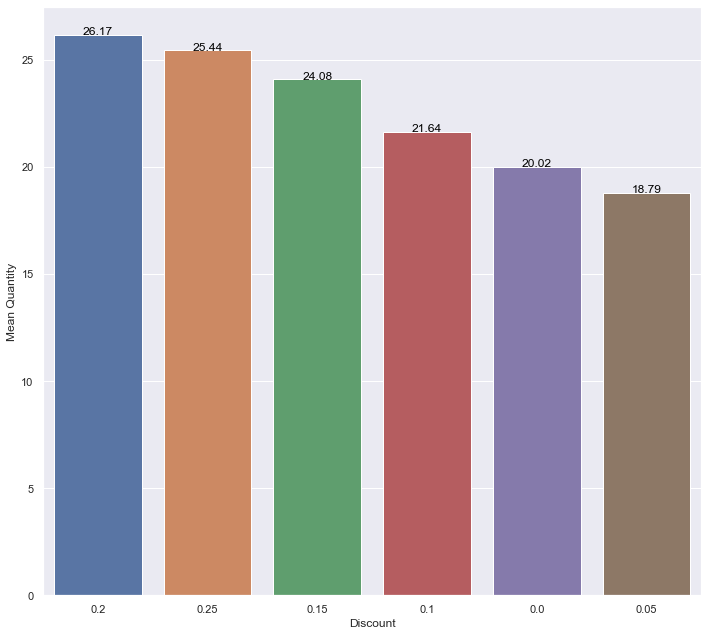

In [37]:
summarize_mean_quantity_by_discount(order_detail_qty_outliers_removed_df_2, sort=True)

One VERY interesting note is that after cleaning all outliers, **a 20% discount appears to increase *Quantity* of products ordered the most, on average**.

So, at this point, we should think that this is NOT due to some mere statistical anomaly!

Additionally, we see the negative effect of a 5% discount in plain view.

Let's get an official measure of effect size of each mean **Quantity** (compared to orders with no discount) via **Cohen's D**:

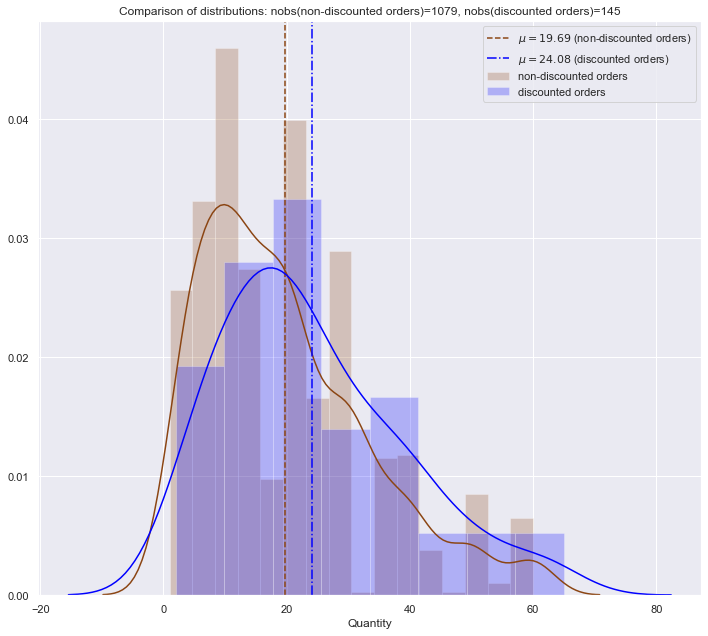

effect size on mean <b>Quantity</b> of products ordered with a 15.0% discount is -0.32 (small) with $\mu=19.69$ and $\mu_d=24.08$ <br><br><br>

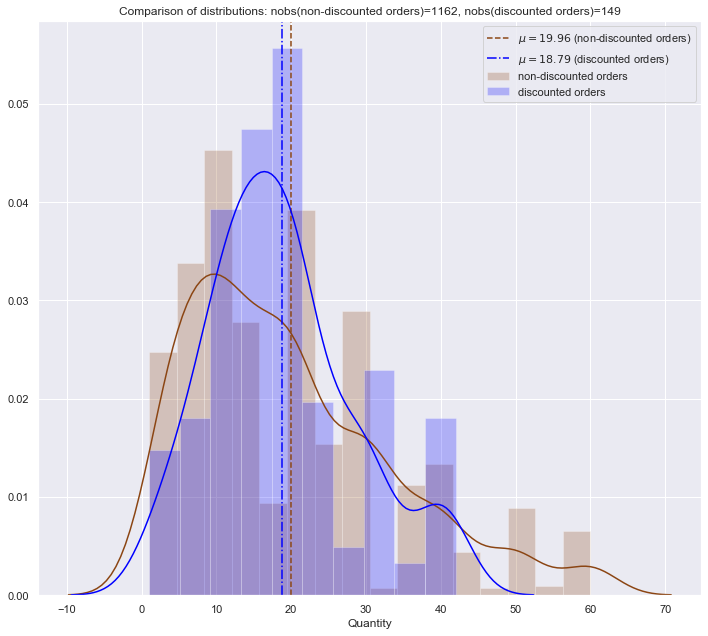

effect size on mean <b>Quantity</b> of products ordered with a 5.0% discount is 0.09 (nominal) with $\mu=19.96$ and $\mu_d=18.79$ <br><br><br>

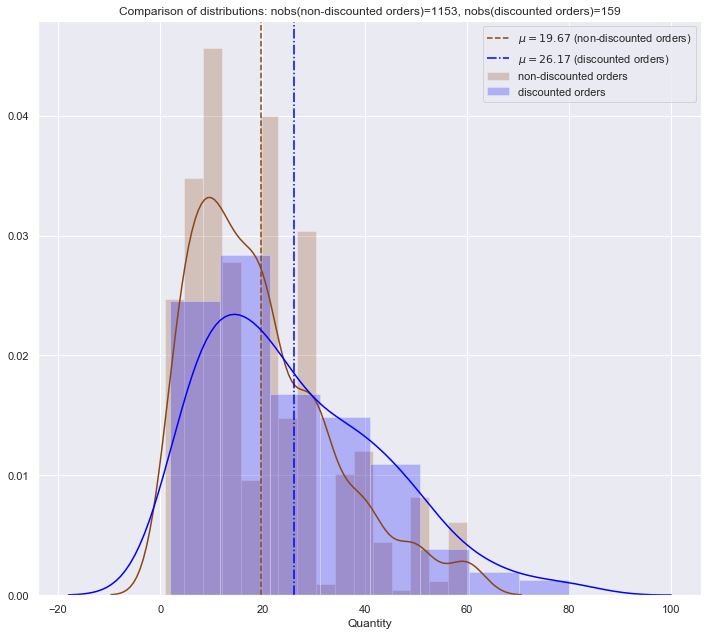

effect size on mean <b>Quantity</b> of products ordered with a 20.0% discount is -0.46 (small) with $\mu=19.67$ and $\mu_d=26.17$ <br><br><br>

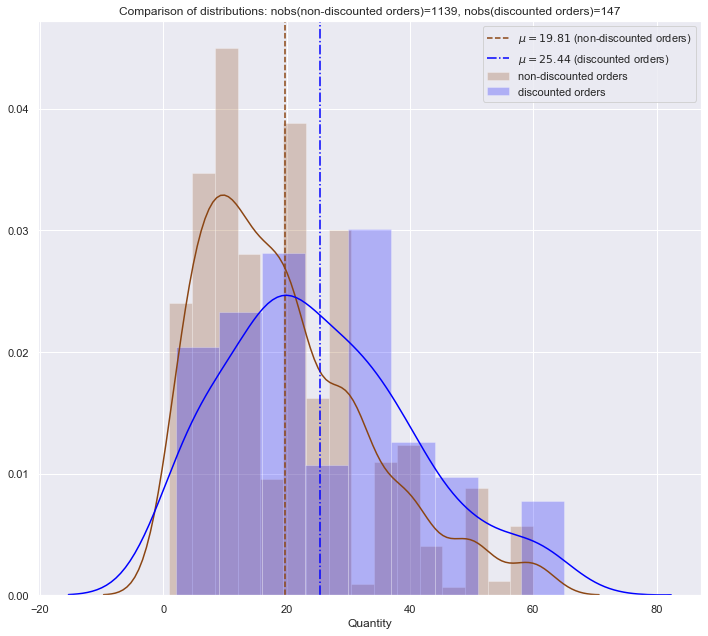

effect size on mean <b>Quantity</b> of products ordered with a 25.0% discount is -0.4 (small) with $\mu=19.81$ and $\mu_d=25.44$ <br><br><br>

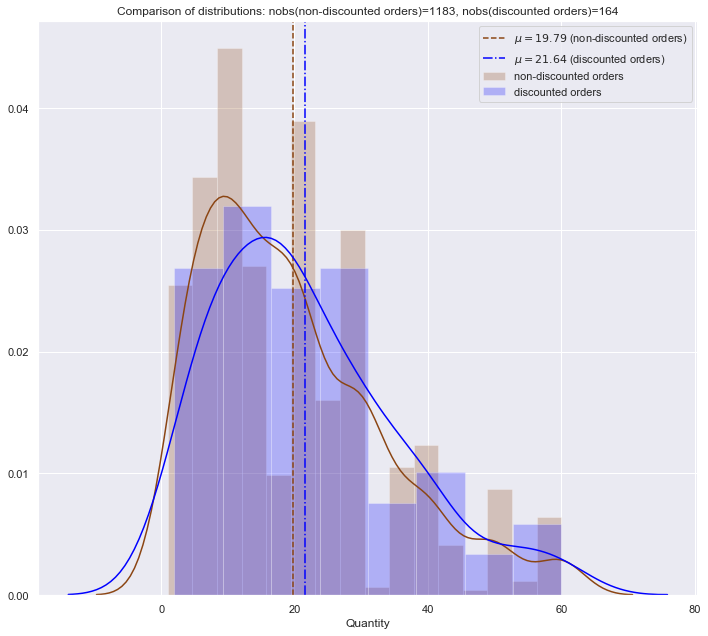

effect size on mean <b>Quantity</b> of products ordered with a 10.0% discount is -0.13 (nominal) with $\mu=19.79$ and $\mu_d=21.64$ <br><br><br>

<br><h3>SUMMARY:</h3>

discounts that result in an increase in <b>Quantity</b> on a per-product basis, ordered by effect size, are: [0.2, 0.25, 0.15, 0.1]

discounts that result in a decrease in <b>Quantity</b> on a per-product basis, ordered by effect size, are: [0.05]

<b>on average, a 20.0% discount INCREASES the <i>Quantity</i> of ordered products the most</b> by $\mu_d=26.17 - \mu=19.67 = 6.5$

**on average, customers receiving a 20.0% discount ordered 1.33 times as many products as customers not receiving a discount**<p><br>

<b>on average, a 5.0% discount DECREASES the <i>Quantity</i> of ordered products!  DON'T DO IT! $\mu_d=18.79 - \mu=19.96 = -1.18$</b>

**on average, customers receiving a 5.0% discount ordered 0.94 times as many products as customers not receiving a discount**

In [38]:
d_no_diff_qty = [] # discounts having no effect on quantity
d_higher_qty = [] # discounts that result in greater quantities on a per product basis
d_lower_qty = [] # discounts that result in greater quantities on a per product basis

for d in orders_with_discount_df_2.Discount.unique():
    qty_for_discount_df = orders_with_discount_df_2.query(f"Discount=={d}")
    
    distinct_discounted_products_df = pysqldfmgr.pysqldf(f"SELECT DISTINCT ProductId FROM qty_for_discount_df")
    non_discounted_orders_for_those_products = pysqldfmgr.pysqldf(f"""
        SELECT * 
        FROM orders_without_discount_df_2 
        WHERE ProductId IN (SELECT * FROM distinct_discounted_products_df)
    """)
    
    mu = non_discounted_orders_for_those_products.Quantity.mean()
    mu_d = qty_for_discount_df.Quantity.mean()
    
    dist_plot_comparison(
        non_discounted_orders_for_those_products.Quantity
        , qty_for_discount_df.Quantity
        , ["non-discounted orders", "discounted orders"]
    )
    
    _cd = Cohen_d(non_discounted_orders_for_those_products.Quantity, qty_for_discount_df.Quantity)
    display(Markdown(f"effect size on mean <b>Quantity</b> of products ordered with a {d*100}% discount is {round(_cd,2)} ({Cohen_d_qual(_cd)}) with $\\mu={round(mu,2)}$ and $\\mu_d={round(mu_d,2)}$ <br><br><br>"))
    
    # negative Cohen's D means the second mean is greater than the first (i.e. quantities on orders with a discount > those without)
    if _cd < 0:
        d_higher_qty.append((d, _cd, mu, mu_d))
    elif _cd > 0:
        d_lower_qty.append((d, _cd, mu, mu_d))
    else:
        d_no_diff_qty.append((d, _cd, mu, mu_d))

        
# now summarize results
display(Markdown("<br><h3>SUMMARY:</h3>"))
d_higher_qty = sorted(d_higher_qty, key=lambda t: t[1])
d_lower_qty = sorted(d_lower_qty, key=lambda t: t[1])

if len(d_higher_qty) > 0:
    display(Markdown(f"discounts that result in an increase in <b>Quantity</b> on a per-product basis, ordered by effect size, are: {list(map(lambda t: t[0], d_higher_qty))}"))
if len(d_lower_qty) > 0:
    display(Markdown(f"discounts that result in a decrease in <b>Quantity</b> on a per-product basis, ordered by effect size, are: {list(map(lambda t: t[0], d_lower_qty))}"))
if len(d_no_diff_qty) > 0:
    display(Markdown(f"discounts that have no impact on <b>Quantity</b> on a per-product basis are: {sorted(list(map(lambda t: t[0], d_no_diff_qty)))}"))

print()
if len(d_higher_qty) > 0:
    display(Markdown(f"<b>on average, a {d_higher_qty[0][0]*100}% discount INCREASES the <i>Quantity</i> of ordered products the most</b> by $\\mu_d={round(d_higher_qty[0][3],2)} - \\mu={round(d_higher_qty[0][2],2)} = {round(d_higher_qty[0][3]-d_higher_qty[0][2],2)}$"))
    display(Markdown(f"**on average, customers receiving a {d_higher_qty[0][0]*100}% discount ordered {round(d_higher_qty[0][3]/d_higher_qty[0][2],2)} times as many products as customers not receiving a discount**<p><br>"))
if len(d_lower_qty) > 0:
    display(Markdown(f"<b>on average, a {d_lower_qty[-1][0]*100}% discount DECREASES the <i>Quantity</i> of ordered products!  DON'T DO IT! $\\mu_d={round(d_lower_qty[-1][3],2)} - \\mu={round(d_lower_qty[-1][2],2)} = {round(d_lower_qty[-1][3]-d_lower_qty[-1][2],2)}$</b>"))
    display(Markdown(f"**on average, customers receiving a {d_lower_qty[-1][0]*100}% discount ordered {round(d_lower_qty[-1][3]/d_lower_qty[-1][2],2)} times as many products as customers not receiving a discount**"))

<br><br>

# QUESTION 2

## Define scope of analysis and build hypotheses

The goal of this section is to answer the question:

    Does discount amount have a statistically significant effect on INCREASING revenue? If so, at what level(s) of discount?
    
    
1. let $\mu$ denote the mean **Subtotal** of all product $p \in D$ appearing on orders WITHOUT a discount
2. let $\mu_d$ denote the mean **Subtotal** of all product $p \in D$ appearing on orders WITH a discount

Then our null hypothesis is:

$H_0$: $\mu_d \le \mu$.

And our alternate hypothesis is:

$H_a$: $\mu_d > \mu$.

<br><br>


### Load all tables in the scope into data frames for ease of manipulation and show high-level summary

For this analysis, all the data we require is sourced from the **OrderDetail** table joined to the **Product** table joined to the **Category** table.

We will make use of the `order_detail_qty_outliers_removed_df_2` data frame since it has already been cleaned.

In [39]:
q2_scope = {
    'OrderDetail': order_detail_qty_outliers_removed_df_2
    , 'Product': None
    , 'Category': None
}
q2_scope, q2_scope_tables_with_nulls = summarize_scope(q2_scope, init=True)

#### Scope Summary:<br>

Table <b>OrderDetail</b>:

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2154
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2047 non-null   object 
 1   OrderId    2047 non-null   int64  
 2   ProductId  2047 non-null   int64  
 3   UnitPrice  2047 non-null   float64
 4   Quantity   2047 non-null   int64  
 5   Discount   2047 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 191.9+ KB


Table <b>Product</b>:

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               77 non-null     int64  
 1   ProductName      77 non-null     object 
 2   SupplierId       77 non-null     int64  
 3   CategoryId       77 non-null     int64  
 4   QuantityPerUnit  77 non-null     object 
 5   UnitPrice        77 non-null     float64
 6   UnitsInStock     77 non-null     int64  
 7   UnitsOnOrder     77 non-null     int64  
 8   ReorderLevel     77 non-null     int64  
 9   Discontinued     77 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


Table <b>Category</b>:

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, and seasonings"
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            8 non-null      int64 
 1   CategoryName  8 non-null      object
 2   Description   8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


## Clean Null Values (if necessary)

In [40]:
summarize_scope_tables_with_nulls(q2_scope, q2_scope_tables_with_nulls)

Now we can move on to...

<br>

## Investigate and handle potential outlier values

There are no new continuous features we are pulling into our study in order to answer this question - **Subtotal** is computed from existing cleaned data.

Thus, there is no data-scrubbing work to be done in order to answer this question.

We can, therefore, dive right into our analysis.

In [41]:
product_df = q2_scope['Product']
prod_cat_df = q2_scope['Category']

order_with_prod_detail_df = pysqldfmgr.pysqldf(f"""
    SELECT 
        OrderId
        , ProductId
        , product_df.UnitPrice
        , Quantity
        , Discount
        , CategoryId
        , (product_df.UnitPrice * Quantity * (1 - Discount)) AS Subtotal
    FROM 
        order_detail_qty_outliers_removed_df_2
    JOIN 
        product_df ON ProductId = product_df.Id
    JOIN 
        prod_cat_df ON CategoryId = prod_cat_df.Id
    ORDER BY 
        OrderId ASC
""")

discounted_order_with_prod_detail_df = pysqldfmgr.pysqldf(f"SELECT * FROM order_with_prod_detail_df WHERE Discount>0")
# distinct_discounted_products_df = pysqldfmgr.pysqldf(f"SELECT DISTINCT ProductId FROM discounted_order_with_prod_detail_df")
# non_discounted_order_with_prod_detail_df = pysqldfmgr.pysqldf(f"""
#     SELECT * 
#     FROM order_with_prod_detail_df 
#     WHERE Discount=0 AND ProductId IN (SELECT * FROM distinct_discounted_products_df)
# """)
non_discounted_order_with_prod_detail_df = pysqldfmgr.pysqldf(f"""
    SELECT * 
    FROM order_with_prod_detail_df 
    WHERE Discount=0
""")

<br><br>

### Normality Test

In [42]:
is_normal, p_val = normality_test(non_discounted_order_with_prod_detail_df.Subtotal, alpha, "distribution of Subtotal values for orders without discounts")
print(f"len(non_discounted_order_with_prod_detail_df.Subtotal)={len(non_discounted_order_with_prod_detail_df.Subtotal)}")
is_normal, p_val_d = normality_test(discounted_order_with_prod_detail_df.Subtotal, alpha, "distribution of Subtotal values for orders WITH discounts")
print(f"len(discounted_order_with_prod_detail_df.Subtotal)={len(discounted_order_with_prod_detail_df.Subtotal)}")

$p\_val\ (0.0) < \alpha\ (0.05) \implies$ distribution of Subtotal values for orders without discounts is NOT normal

len(non_discounted_order_with_prod_detail_df.Subtotal)=1283


$p\_val\ (1.9310054333510163e-207) < \alpha\ (0.05) \implies$ distribution of Subtotal values for orders WITH discounts is NOT normal

len(discounted_order_with_prod_detail_df.Subtotal)=764


<br>

### Equal-variance Test

In [43]:
v_no_discount = np.var(non_discounted_order_with_prod_detail_df.Subtotal)
print(f"Subtotals of orders without a discount has variance: {v_no_discount}.")
v_discounted = np.var(discounted_order_with_prod_detail_df.Subtotal)
print(f"Subtotals of orders WITH a discount has variance: {v_discounted}.")

equal_var, p_val = equal_variance_test(non_discounted_order_with_prod_detail_df.Subtotal, discounted_order_with_prod_detail_df.Subtotal, alpha)

Subtotals of orders without a discount has variance: 858312.5572904173.
Subtotals of orders WITH a discount has variance: 779073.8785941472.


$p\_val\ (0.8010663020398588) \ge \alpha\ (0.05) \implies$ samples ARE from populations with equal variances

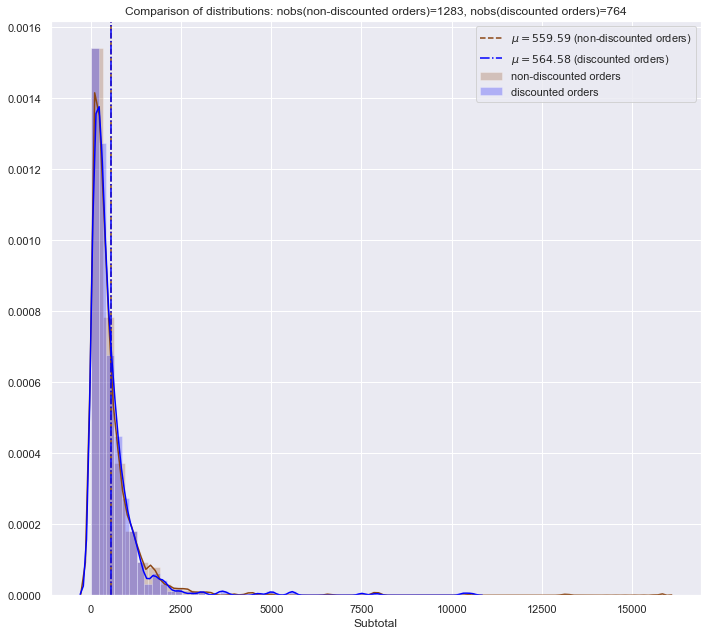

In [44]:
dist_plot_comparison(
    non_discounted_order_with_prod_detail_df.Subtotal
    , discounted_order_with_prod_detail_df.Subtotal
    , ["non-discounted orders", "discounted orders"]
)

Let's magnify this a bit...

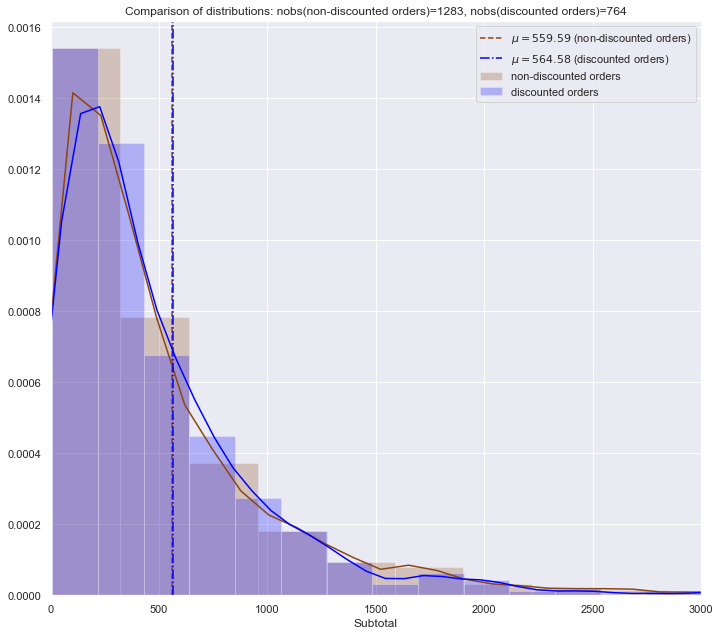

effect size on mean <b>Subtotal</b> of products ordered with any discount is -0.01 (nominal) with $\mu=559.59$ and $\mu_d=564.58$ <br><br><br>

In [45]:
dist_plot_comparison(
    non_discounted_order_with_prod_detail_df.Subtotal
    , discounted_order_with_prod_detail_df.Subtotal
    , ["non-discounted orders", "discounted orders"]
    , color=[c_no_disc, c_disc], 
    restricted_domain=[0,3000]
)

cd = Cohen_d(non_discounted_order_with_prod_detail_df.Subtotal, discounted_order_with_prod_detail_df.Subtotal)
display(Markdown(f"effect size on mean <b>Subtotal</b> of products ordered with any discount is {round(cd,2)} ({Cohen_d_qual(cd)}) with $\\mu={round(non_discounted_order_with_prod_detail_df.Subtotal.mean(),2)}$ and $\\mu_d={round(discounted_order_with_prod_detail_df.Subtotal.mean(),2)}$ <br><br><br>"))

<br>

### 2 Sample Welch T-Test (One-tailed and Two-tailed)

Apparently, according to "industry standard", so long as sample sizes > 30, T-Tests (including Welch's T-Test) are still generally employed even when distributions are not normal.

Let's see what the **One-tailed 2-sample Welch T-Test** tells us about our hypothesis.

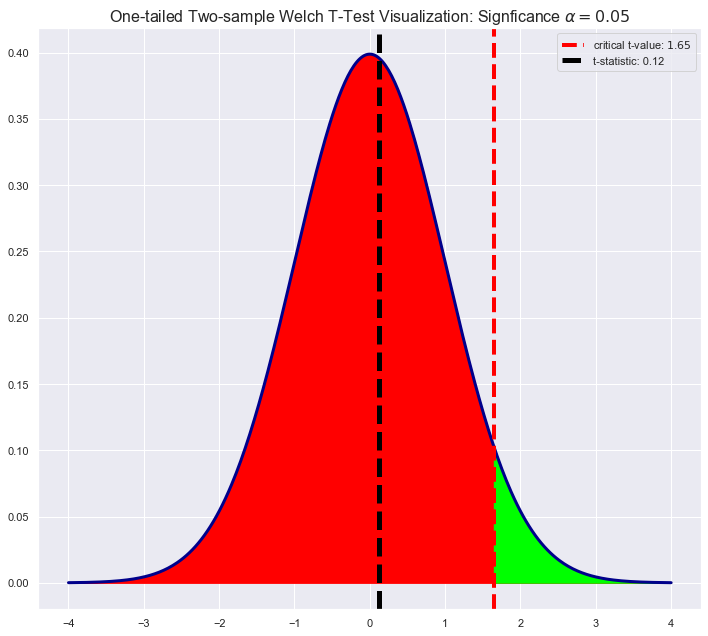

<p><br>

95.0% confidence $\Delta \mu$ is in interval: (-52.553, 62.53)

$\mu_1=564.582$ in rejection region $(588.364, 593.353]$: False

$\mu_2=559.593$ in rejection region $[530.822, 535.811)$: False

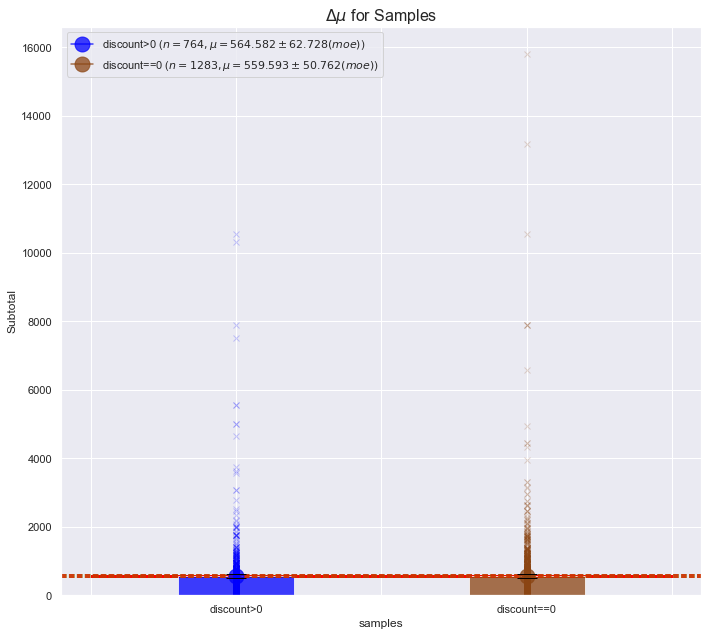

$p\_val\ (0.4517241819080423) \ge \alpha\ (0.05) \implies$ $\mu_d \le\mu$.

In [46]:
mu_d_gt_mu, p_val = t_test_2_samp(
    discounted_order_with_prod_detail_df.Subtotal
    , non_discounted_order_with_prod_detail_df.Subtotal
    , alpha
    , xlabels=['discount>0','discount==0']
    , ylabel='Subtotal'
    , is_welch=True,
    one_tailed_type='greater'
)
display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override="$\\mu_d " + (">" if mu_d_gt_mu else "\\le") + "\\mu$.")))

#store one-tailed p-val for comparison to that obtained by monte-carlo
p_val_one_tailed = p_val

Thus, ***One-tailed Welch T-Test*** tells us that that $\mu_d \le \mu$.

So now we need to get more specific and use ***Two-tailed Welch T-Test*** in order to determine whether $\mu_d = \mu$ or not.

We can already see that the t-statistic for the two-tailed version of test will fail to reject the null hypothesis.

But for the sake of completeness, we run the test anyway...

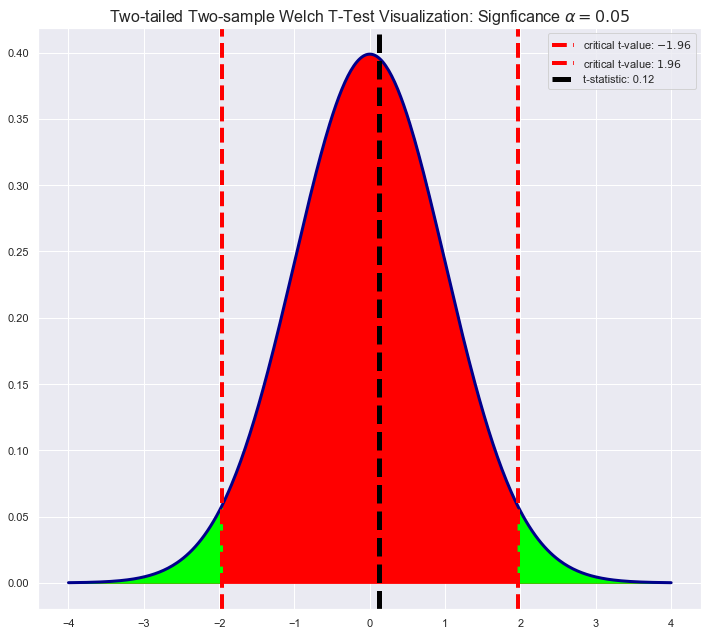

<p><br>

95.0% confidence $\Delta \mu$ is in interval: (-63.589, 73.566)

$\mu_1=564.582$ in rejection region $(593.882, 598.87]$: False

$\mu_2=559.593$ in rejection region $[525.305, 530.293)$: False

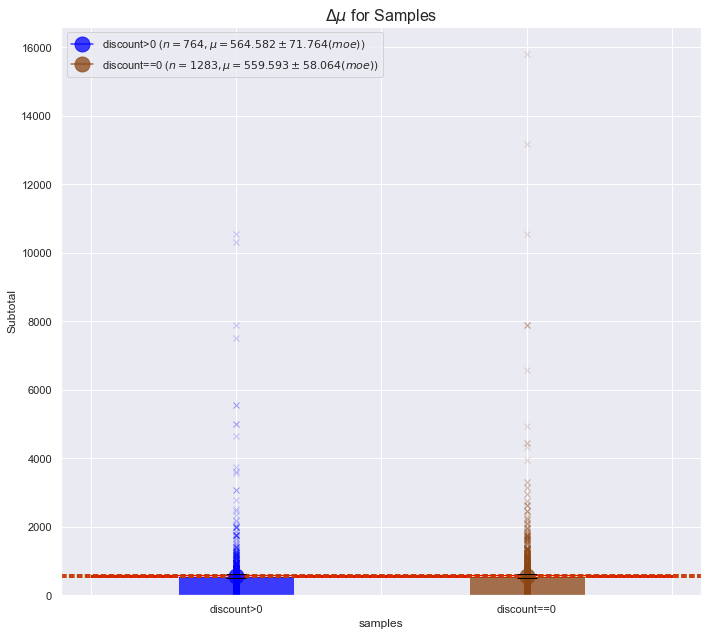

$p\_val\ (0.9034483638160846) \ge \alpha\ (0.05) \implies$ $\mu_d =\mu$.

In [47]:
equal_means, p_val = t_test_2_samp(
    discounted_order_with_prod_detail_df.Subtotal
    , non_discounted_order_with_prod_detail_df.Subtotal
    , alpha
    , xlabels=['discount>0','discount==0']
    , ylabel='Subtotal'
    , is_welch=True
)
display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override="$\\mu_d " + ("=" if equal_means else "\\ne") + "\\mu$.")))

Thus, the ***Two-tailed T-Test*** suggests that **discount does NOT have a statistically significant effect on revenue**.

With the ***Kolmogorov-Smirnov Test***, we can get a *feel* for the probability of a given subtotal occuring by inspecting the corresponding CDFs from orders with and without a discount.  We might be able to infer something about the relative difference in means by looking at the corresponding CDFs.

<br>

### Kolmogorov-Smirnov Test

According to the `scipy.stats.ks_2samp` documentation:

    In the one-sided test, the alternative is that the empirical cumulative distribution function F(x) of the data1 variable is “less” or “greater” than the empirical cumulative distribution function G(x) of the data2 variable, F(x)<=G(x), resp. F(x)>=G(x).
    
Thus, passing `alternative="greater"`, we have:

1. $H_a: F(x) > G(x)$
2. $H_0: F(x) <= G(x)$

Here, `data1=non_discounted_order_with_prod_detail_df` and `data2=discounted_order_with_prod_detail_df.Subtotal`.

What we wish to show with this test is the relative difference in probabilities for a given subtotal occurring.

The reasoning is that if the probability of a given subtotal occurring is consistently different in one sample vs. the other, we can LOOSELY infer a similar relationship between the sample subtotal means.

Note that this is NOT a substitute for other tests based on mean.

This is just supplemental information to support other mean-based tests and provide further insight.

In [48]:
ks_stat, p_val = stats.ks_2samp(
    discounted_order_with_prod_detail_df.Subtotal
    , non_discounted_order_with_prod_detail_df.Subtotal
    , alternative="greater"
)
# h_null: mu_d <= mu
# h_a: mu_d > mu

display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override="$CDF_d(Subtotal) " + (">" if p_val < alpha else "\\le") + " CDF(Subtotal)$.")))

$p\_val\ (0.7051354401758021) \ge \alpha\ (0.05) \implies$ $CDF_d(Subtotal) \le CDF(Subtotal)$.

That is, overall, the probability of a subtotal occurring on orders with a discount is not greater than that of orders without a discount.

To get an additional feel for this, let's plot the above.

In [49]:
def ks_plot_2sample(data_1, data_2, labels, restricted_domain=None):
    '''
    Data entered must be the same size.
    '''
    #differing sizes won't break execution since we use a combined domain, according to the lecture:
    #   "we sort the combined sample, in order to compute the empirical cdfs"
    
    # so now combine data_1 with data_2 and then sort
    combined_sorted = np.sort(np.append(data_1, data_2))

    #now compute the CDFs from the combined domain
    F_data_1 = []
    F_data_2 = []
    for csv in combined_sorted:
        p_obs_lte_csv__data_1 = len(np.where(data_1<=csv)[0])/len(data_1) #count of data_1 observations <= current sorted combined value, divided by total number of data_1 observations 
        F_data_1.append(p_obs_lte_csv__data_1)

        p_obs_lte_csv__data_2 = len(np.where(data_2<=csv)[0])/len(data_2) #count of data_2 observations <= current sorted combined value, divided by total number of data_2 observations 
        F_data_2.append(p_obs_lte_csv__data_2)

    # now we can actually create the plots: the CDFs (F-values) are the y-values of the plot, while the x-values are observed values
    fig = plt.figure(figsize=fs_default)
    X_data_1 = X_data_2 = combined_sorted # common domain
    Y_data_1 = F_data_1
    Y_data_2 = F_data_2
    plt.plot(X_data_1, Y_data_1, label=f"Empiracal CDF (of {labels[0]}) with $\\mu={round(data_1.mean(),2)}$", color='red')
    plt.plot(X_data_2, Y_data_2, label=f"Empiracal CDF (of {labels[1]}) with $\\mu={round(data_2.mean(),2)}$", color='blue')
    
    plt.legend()
    plt.title(f"Empiracal CDF Comparison ({labels[0]} and {labels[1]}), Sample Size: {len(combined_sorted)}")
    fig.tight_layout()
    
    if restricted_domain is not None:
        axes = plt.gca()
        axes.set_xlim(restricted_domain)
        
    plt.show();

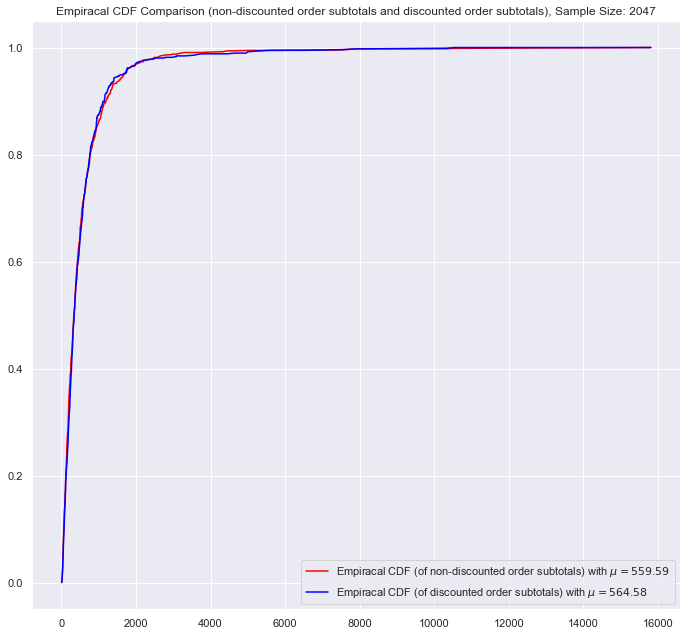

In [50]:
ks_plot_2sample(
    non_discounted_order_with_prod_detail_df.Subtotal
    , discounted_order_with_prod_detail_df.Subtotal
    , ["non-discounted order subtotals", "discounted order subtotals"]
)

Let's magnify this a bit...

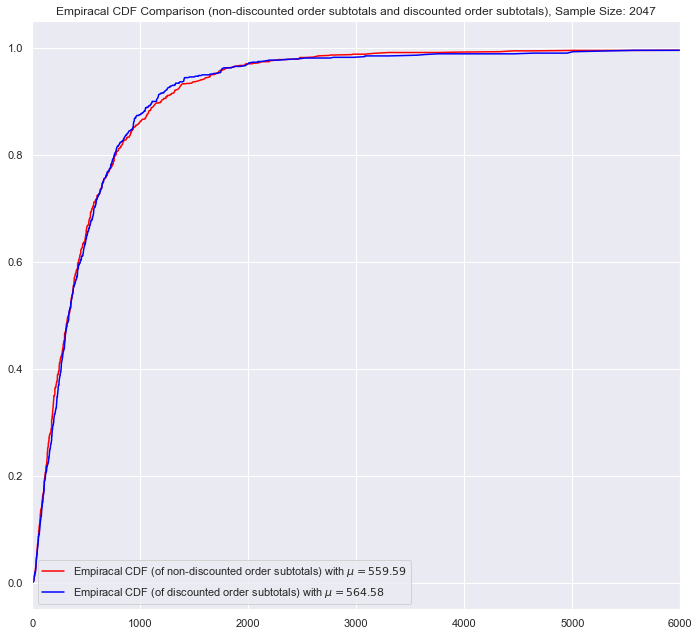

In [51]:
ks_plot_2sample(
    non_discounted_order_with_prod_detail_df.Subtotal
    , discounted_order_with_prod_detail_df.Subtotal
    , ["non-discounted order subtotals", "discounted order subtotals"]
    , [0,6000]
)

Visually speaking, it seems pretty clear that we cannot reject the null hypothesis that $CDF_d(Subtotal) \le CDF(Subtotal)$.

Let me explain...

If, for example, the curve for the CDF of subtotals of orders WITH a discount was consistently shifted to the right and the non-discounted CDF "bowed" to the upper-left more, then that means higher subtotals are in greater proportion in the CDF of subtotals for orders with a discount.  In that case, we could loosely infer that $\mu_d > \mu$ is significantly plausible.

Let's create a hypothetical distribution of subtotals for orders that have received a discount that has a subtantially higher mean **Subtotal** followed by a comparison of their CDF plots.

To do this, we set up the following hypothetical scenario:

1. Introduce a "fake" **Quantity** inflation factor induced by **Discount** > 0.
2. This will naturally result in an *adjusted* order subtotal, inflated by the inflation factor given by formula: **Subtotal_Adj** = **UnitPrice** * (**Quantity** + int(**Quantity** * *qty_inflation_factor*)) * (1 - **Discount**).
3. This results in a similarly shaped distribution but the mean **Subtotal** is substantially greater than the authentic mean **Subtotal** of legitimate orders with **Discount** > 0.

#### First few records of "fake" orders (with inflated Quantity and Subtotal IF given Discount == 0)

,OrderId,ProductId,UnitPrice,Quantity,Qty_inflated,Discount,CategoryId,Subtotal,Subtotal_inflated
0,10248,11,21.00,12,12,0.0,4,252.00,252.00
1,10248,42,14.00,10,10,0.0,5,140.00,140.00
2,10248,72,34.80,5,5,0.0,4,174.00,174.00
3,10249,14,23.25,9,9,0.0,7,209.25,209.25
4,10249,51,53.00,40,40,0.0,7,2120.00,2120.00


#### First few records of "fake" orders (with inflated Quantity and Subtotal IF given Discount > 0)

,OrderId,ProductId,UnitPrice,Quantity,Qty_inflated,Discount,CategoryId,Subtotal,Subtotal_inflated
0,10250,51,53.00,35,70,0.15,7,1576.7500,3153.500
1,10250,65,21.05,15,30,0.15,2,268.3875,536.775
2,10251,22,21.00,6,12,0.05,5,119.7000,239.400
3,10251,57,19.50,15,30,0.05,5,277.8750,555.750
4,10252,20,81.00,40,80,0.05,3,3078.0000,6156.000


#### Distributions of Subtotals of real vs fake orders, both with Discount > 0, are similarly shaped

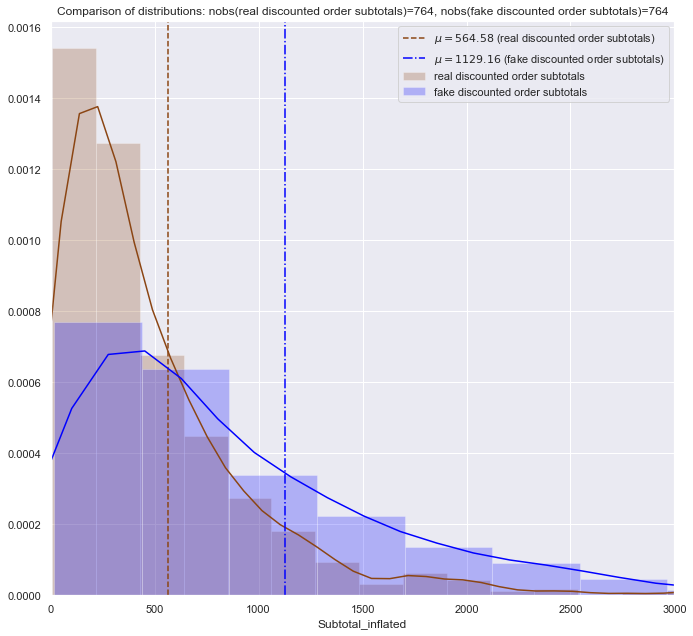

#### Distributions of Subtotals ALL (discounted or not) orders vs fake orders with Discount > 0

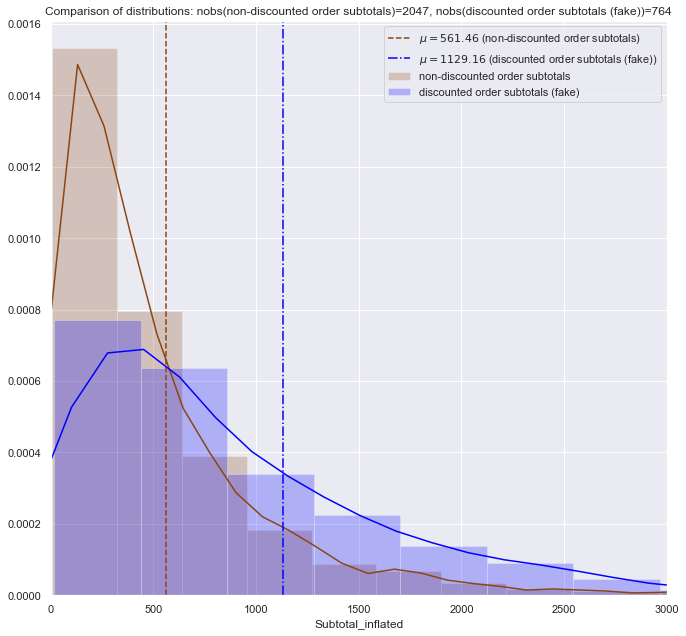

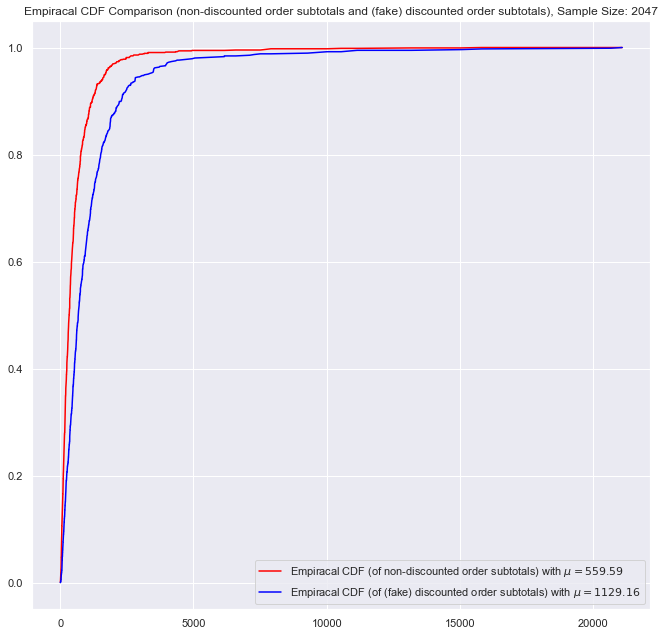

In [52]:
hyp_mu_delta = 100

fake_qty_inflation_factor = 1

fake_order_with_prod_detail_df = pysqldfmgr.pysqldf(f"""
    SELECT 
        OrderId
        , ProductId
        , product_df.UnitPrice
        , Quantity
        , CASE 
            WHEN Discount > 0
                THEN Quantity + cast((Quantity*{fake_qty_inflation_factor}) AS INT)
            ELSE
                Quantity
            END AS Qty_inflated
        , Discount
        , CategoryId
        , (product_df.UnitPrice * Quantity * (1 - Discount)) AS Subtotal
        , CASE 
            WHEN Discount > 0
                THEN (product_df.UnitPrice * (Quantity + cast((Quantity*{fake_qty_inflation_factor}) AS INT)) * (1 - Discount))
            ELSE
                (product_df.UnitPrice * Quantity * (1 - Discount))
            END AS Subtotal_inflated
    FROM 
        order_detail_qty_outliers_removed_df_2
    JOIN 
        product_df ON ProductId = product_df.Id
    JOIN 
        prod_cat_df ON CategoryId = prod_cat_df.Id
    ORDER BY 
        OrderId ASC
""")
fake_discounted_order_with_prod_detail_df = pysqldfmgr.pysqldf(f"SELECT * FROM fake_order_with_prod_detail_df WHERE Discount > 0")

display(Markdown("#### First few records of \"fake\" orders (with inflated Quantity and Subtotal IF given Discount == 0)"))
scjpnutils.print_df_head(fake_order_with_prod_detail_df)
display(Markdown("#### First few records of \"fake\" orders (with inflated Quantity and Subtotal IF given Discount > 0)"))
scjpnutils.print_df_head(fake_discounted_order_with_prod_detail_df)

mu = fake_discounted_order_with_prod_detail_df.Subtotal.mean()
mu_inflated = fake_discounted_order_with_prod_detail_df.Subtotal_inflated.mean()

display(Markdown("#### Distributions of Subtotals of real vs fake orders, both with Discount > 0, are similarly shaped"))
dist_plot_comparison(
    discounted_order_with_prod_detail_df.Subtotal
    , fake_discounted_order_with_prod_detail_df.Subtotal_inflated
    , ["real discounted order subtotals", "fake discounted order subtotals"]
    , color=[c_no_disc, c_disc], 
    restricted_domain=[0,3000]
)

display(Markdown("#### Distributions of Subtotals ALL (discounted or not) orders vs fake orders with Discount > 0"))
dist_plot_comparison(
    order_with_prod_detail_df.Subtotal
    , fake_discounted_order_with_prod_detail_df.Subtotal_inflated
    , ["non-discounted order subtotals", "discounted order subtotals (fake)"]
    , color=[c_no_disc, c_disc], 
    restricted_domain=[0,3000]
)

ks_plot_2sample(
    non_discounted_order_with_prod_detail_df.Subtotal
    , fake_discounted_order_with_prod_detail_df.Subtotal_inflated
    , ["non-discounted order subtotals", "(fake) discounted order subtotals"]
)

The point in all of the above work is to show that, with a `ks_2samp` plots such as those above, we can LOOSELY infer relationships about the mean comparisons.

With the first, we see the inference that $\mu_d \le \mu$.

With the second, we can (loosely) infer that $\mu_d > \mu$.

Another way to interpret this is as follows:

    For a given probability, p, from the CDF, p represents the proportion of Subtotals less-than-or-equal to the value in the domain (along the x-axis).
    
For example, in the above hypothetical scenario, for $p=0.8$, we see that 80% of the Subtotals of orders WITH a discount are approximately less-than-or-equal to 5000/3 dollars, whereas 80% of the Subtotals of orders WITHOUT a discount are approximately less-than-or-equal to 5000/6 dollars.

<br>

BUT WE SEE THE FORMER (actual) CDFs, NOT THE LATTER!  

The frequency of occurrence of any given subtotal appears to be virtually identical in both, in the former (actual) CDFs.

This further supports that **EVIDENCE DOES NOT SUGGEST that discount has a statistically significant effect on revenue**.

But to tie a bow on this experiment, let's be sure it is not merely the data.  

Let's run this experiment through Monte Carlo...

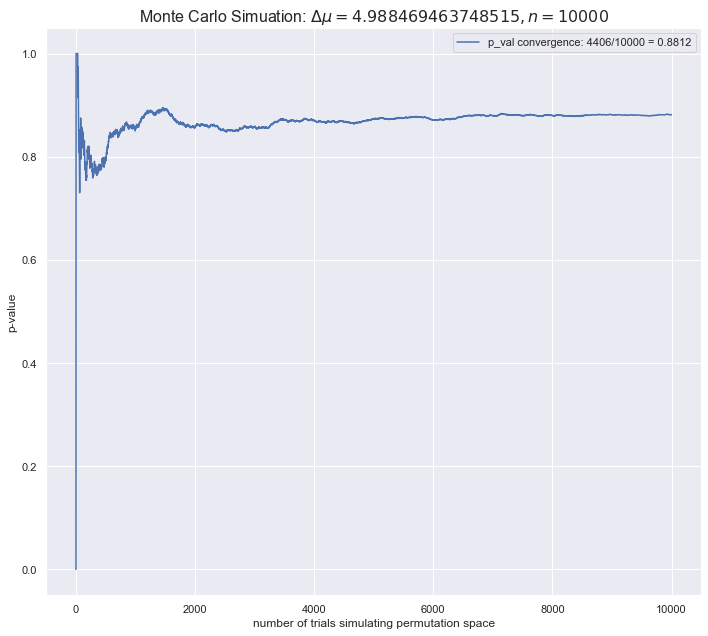

$p\_val\ (0.8812) \ge \alpha\ (0.05) \implies$ $\mu_t =\mu_{null}$.<br><br>

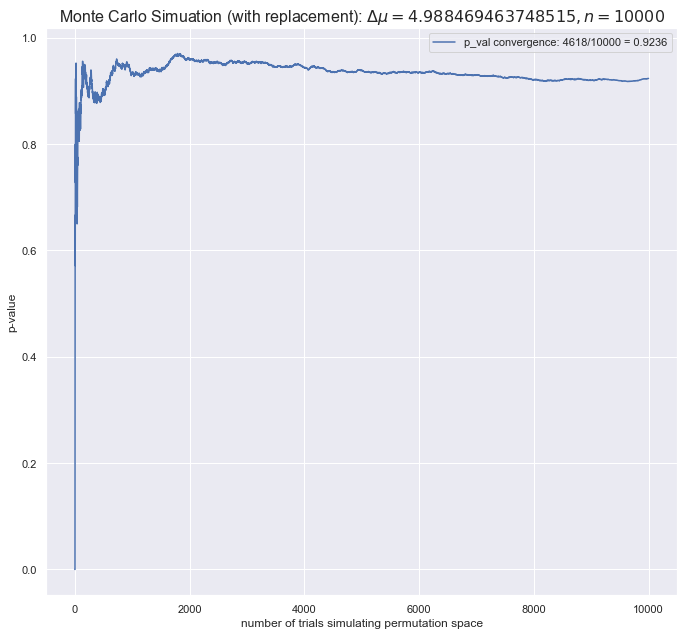

$p\_val\ (0.9236) \ge \alpha\ (0.05) \implies$ $\mu_t =\mu_{null}$.<br><br>

mean monte carlo p-val (between with and without replacement) is: 0.9024
2 * p-val from one-tailed t-test is: 0.9034483638160846
difference is: 0.001048363816084641


In [53]:
p_val = monte_carlo_test(
    non_discounted_order_with_prod_detail_df.Subtotal
    , discounted_order_with_prod_detail_df.Subtotal
    , n_simulations
)

p_val_with_replacement = monte_carlo_test(
    non_discounted_order_with_prod_detail_df.Subtotal
    , discounted_order_with_prod_detail_df.Subtotal
    , n_simulations
    , with_replacement=True
)

p_val_mc_mean = (p_val + p_val_with_replacement)/2
print(f"mean monte carlo p-val (between with and without replacement) is: {p_val_mc_mean}")
print(f"2 * p-val from one-tailed t-test is: {2*p_val_one_tailed}")
print(f"difference is: {abs(p_val_mc_mean-(2*p_val_one_tailed))}")

<br>

The ***Monte Carlo simulation*** agrees with $2 \cdot pval$ from ***One-tailed 2-sample T-Test*** in this case with a very small error.

Thus, it is abundantly clear that **there is no evidence to suggest that offering a discount will increase revenue**.

<br><br>

## SUMMARY:

**No test conducted in this section suggests there is evidence to support that offering a discount will increase revenue.**

In conjunction with the result from the last section, while there is evidence to suggest offering a discount increases the quantity of products ordered, and since this section indicates that there is no evidence to suggest that doing so will increase revenue overall, it may seem pointless to offer a discount.

### RECOMMENDATION:
**Investigate whether or not a discount campaign promotes repeat business, thereby increasing revenue in the future.**

<br><br>

# QUESTION 3

## Define scope of analysis and build hypotheses

The goal of this section is to address the recommendation from the last section:

    Given that a customer has received a discount in the past, does that customer tend to place more orders than customers not receiving any discount?  If so, what discount rate induces the highest post-discount order rate?  Additionally, is the post-discount non-discounted order rate higher than the order-rate of customers never receiving a discount?
    
This question is fundamentally about the *Poisson Distribution* of order frequencies.

We have to take care in how we formulate the hypotheses.

First, we need to answer the question:

    For each customer receving a discount, what is their daily order rate AFTER THE FIRST DISCOUNT.
    
What we want to measure here is the order rate AFTER the first discount compared to the order rate of customers not receiving ANY discount (ever).

Second, we need a common termination date for both customers that received discounts and those that did not.

The reason is that we can get a false sense of order rate if non-discounted customer orders frequently over a short span and then never orders again.

So, this is why we use a common study-termination date, which is defined as the LAST date of ALL orders.
    
0. Let $dt_{term} = max(date)$ of all orders.
1. let $\mu_d$ denote the mean **OrdersPerDay** for customers that received a discount, which is computed as follows:
    1. Let $dt_{0,d}$ be the date of the customer's first DISCOUNTED order.
    2. Let $n_d$ be the count of ALL orders for this customer (regardless of discount) having $dt_{0,d} \le date \le dt_{term}$.
    3. Then $\mu_d = mean(\forall \frac{n_d}{dt_{term} - dt_{0,d}})$
2. let $\mu$ denote the mean **OrdersPerDay** for customers that have never received a discount on ANY order, which is computed as follows:
    1. Let $dt_0$ be the date of the customer's first order.
    2. Let $n$ be the count of all orders for this customer having $dt_0 \le date \le dt_{term}$.
    3. Then $\mu = mean(\forall \frac{n}{dt_{term} - dt_0})$
    

Then our null hypothesis is:

$H_0$: $\mu_d \le \mu$.

And our alternate hypothesis is:

$H_a$: $\mu_d > \mu$.

<br><br>


### Load all tables in the scope into data frames for ease of manipulation and show high-level summary

For this analysis, all the data we require is sourced from the **OrderDetail** table joined to the **Customer** table.

We will make use of the `order_detail_qty_outliers_removed_df_2` data frame since it has already been cleaned.

In [54]:
q3_scope = {
    'Order': None
    , 'OrderDetail': order_detail_qty_outliers_removed_df_2
    , 'Customer': None
}
q3_scope, q3_scope_tables_with_nulls = summarize_scope(q3_scope, init=True)

#### Scope Summary:<br>

Table <b>Order</b>:

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              830 non-null    int64  
 1   CustomerId      830 non-null    object 
 2   EmployeeId      830 non-null    int64  
 3   OrderDate       830 non-null    object 
 4   RequiredDate    830 non-null    object 
 5   ShippedDate     809 non-null    object 
 6   ShipVia         830 non-null    int64  
 7   Freight         830 non-null    float64
 8   ShipName        830 non-null    object 
 9   ShipAddress     830 non-null    object 
 10  ShipCity        830 non-null    object 
 11  ShipRegion      830 non-null    object 
 12  ShipPostalCode  811 non-null    object 
 13  ShipCountry     830 non-null    object 
dtypes: float64(1), int64(3), object(10)
memory usage: 90.9+ KB


Table <b>OrderDetail</b>:

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2154
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2047 non-null   object 
 1   OrderId    2047 non-null   int64  
 2   ProductId  2047 non-null   int64  
 3   UnitPrice  2047 non-null   float64
 4   Quantity   2047 non-null   int64  
 5   Discount   2047 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 191.9+ KB


Table <b>Customer</b>:

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            91 non-null     object
 1   CompanyName   91 non-null     object
 2   ContactName   91 non-null     object
 3   ContactTitle  91 non-null     object
 4   Address       91 non-null     object
 5   City          91 non-null     object
 6   Region        91 non-null     object
 7   PostalCode    90 non-null     object
 8   Country       91 non-null     object
 9   Phone         91 non-null     object
 10  Fax           69 non-null     object
dtypes: object(11)
memory usage: 7.9+ KB


['Order', 'Customer']


<br>

## Clean Null Values (if necessary)

In [55]:
summarize_scope_tables_with_nulls(q3_scope, q3_scope_tables_with_nulls)

,name,index,dtype,n_null
0,ShippedDate,5,object,21
1,ShipPostalCode,12,object,19


,name,index,dtype,n_null
0,PostalCode,7,object,1
1,Fax,10,object,22


None of these columns are relevant to the hypotheses in the Question 3 scope.

Therefore, we can move on to...

<br>

## Investigate and handle potential outlier values

There are no new continuous features we are pulling into our study in order to answer this question - **OrdersPerDay** is computed from existing cleaned data.

Thus, there is no data-scrubbing work to be done in order to answer this question.

We can, therefore, dive right into our analysis.

In [56]:
order_df = q3_scope['Order']
customer_df = q3_scope['Customer']

order_detail_for_customer_df = pysqldfmgr.pysqldf(f"""
    SELECT  DISTINCT
        CustomerId
        , OrderId
        , OrderDate
        , Discount
    FROM 
        order_detail_qty_outliers_removed_df_2
    JOIN 
        order_df ON OrderId = order_df.Id
    JOIN 
        customer_df ON CustomerId = customer_df.Id
""")

order_detail_for_customer_df

term_date = order_detail_for_customer_df.OrderDate.max()
display(Markdown(f"term date of this sub-study - that is, the last date of ALL orders - is {term_date}"))

term date of this sub-study - that is, the last date of ALL orders - is 2014-05-06

<br>

### Sub-step 1: build *time-series* to find order rates of all customers that received a discount, after the first order on which a discount was received

In [57]:
orders_for_customers_discounted_df = pysqldfmgr.pysqldf(f"""
    SELECT DISTINCT
        CustomerId AS CustId
        , OrderId
        , OrderDate
        , Discount
    FROM 
        order_detail_for_customer_df
    WHERE
        Discount > 0
""")

grouped_order_dates = orders_for_customers_discounted_df.OrderDate.groupby(orders_for_customers_discounted_df.CustId)
first_discounted_order_date_df = pd.DataFrame()
first_discounted_order_date_df = pd.concat([first_discounted_order_date_df, grouped_order_dates.min()])
first_discounted_order_date_df = first_discounted_order_date_df.reset_index()
first_discounted_order_date_df.columns = ['CustId', 'first_discount_date']

# display(Markdown(f"#### First Discounted Order-Date"))
# scjpnutils.print_df(first_discounted_order_date_df)

# for customers that DID receive a discount, we are interested in ALL orders AFTER (and including) the FIRST disccount date
#   note that this will also obviously include orders after that that are NOT discounted, if any
#   recall, the goal here is to determine if, after receiving a discount, the customer thereafter orders more frequently
all_orders_after_first_discount_df = pysqldfmgr.pysqldf(f"""
    SELECT DISTINCT
        CustomerId
        , OrderId
        , OrderDate
        , Discount
    FROM 
        order_detail_for_customer_df
    WHERE
        OrderDate >= (SELECT first_discount_date FROM first_discounted_order_date_df WHERE CustId=CustomerId)
    ORDER BY CustomerId, OrderDate
""")

In [58]:
ns_per_day = 24*60*60*1000*1000000

def compute_term_order_rate(order_dates_df, term_date):
    grouped_by_customer = order_dates_df.groupby(order_dates_df.CustomerId)
    
    order_dates_grouped_by_customer = grouped_by_customer.OrderDate
    term_order_rate_df = pd.concat([order_dates_grouped_by_customer.min(), order_dates_grouped_by_customer.max()], axis=1)
    term_order_rate_df.columns=['first', 'last']
    term_order_rate_df['delta_days'] = pd.to_datetime(term_order_rate_df['last']) - pd.to_datetime(term_order_rate_df['first'])
    term_order_rate_df['delta_days'] = (term_order_rate_df['delta_days'].astype('int64')/ns_per_day)+1
    term_order_rate_df['OrderCount'] = grouped_by_customer.OrderId.count()
    term_order_rate_df['OrdersPerDay'] = term_order_rate_df['OrderCount']/term_order_rate_df['delta_days']
    term_order_rate_df['term_date'] = term_date
    term_order_rate_df['delta_days_term'] = pd.to_datetime(term_order_rate_df['term_date']) - pd.to_datetime(term_order_rate_df['first'])
    term_order_rate_df['delta_days_term'] = (term_order_rate_df['delta_days_term'].astype('int64')/ns_per_day)+1
    term_order_rate_df['OrdersPerDayTerm'] = term_order_rate_df['OrderCount']/term_order_rate_df['delta_days_term']
    
    return (
        term_order_rate_df.OrdersPerDayTerm.mean()
        , term_order_rate_df.OrdersPerDay.mean()
        , term_order_rate_df
    )

In [59]:
mu_d, _, overall_order_rate_disc_df = compute_term_order_rate(all_orders_after_first_discount_df, term_date)
#display(Markdown("#### Orders/Day After First Discount"))
#scjpnutils.print_df(order_rate_disc_df) #uncomment for verification
display(Markdown(f"$\\mu_d={mu_d}$ (not grouped by discount)")) #for verification (for when we group by discount, next)

$\mu_d=0.03009871248931944$ (not grouped by discount)

In [60]:
def compute_term_order_rate_by_discount(order_dates_df, term_date):
    grouped_by_customer_and_discount = order_dates_df.groupby([order_dates_df.CustomerId, order_dates_df.Discount])
    order_dates_grouped_by_customer_and_discount = grouped_by_customer_and_discount.OrderDate
    order_rate_by_discount_df = pd.concat([order_dates_grouped_by_customer_and_discount.min(), order_dates_grouped_by_customer_and_discount.max()], axis=1)
    order_rate_by_discount_df.columns=['dt_first', 'dt_last']
    order_rate_by_discount_df['delta_days'] = pd.to_datetime(order_rate_by_discount_df['dt_last']) - pd.to_datetime(order_rate_by_discount_df['dt_first'])
    order_rate_by_discount_df['delta_days'] = (order_rate_by_discount_df['delta_days'].astype('int64')/ns_per_day)+1
    order_rate_by_discount_df['OrderCount'] = grouped_by_customer_and_discount.OrderId.count()
    order_rate_by_discount_df['OrdersPerDay'] = order_rate_by_discount_df['OrderCount']/order_rate_by_discount_df['delta_days']
    order_rate_by_discount_df['term_date'] = term_date
    
    #flatten
    flat_order_rate_by_dis_df = order_rate_by_discount_df.reset_index()
    grouped_by_customer = flat_order_rate_by_dis_df.groupby(flat_order_rate_by_dis_df.CustomerId)
    flat_order_rate_by_dis_df = flat_order_rate_by_dis_df.set_index('CustomerId')
    
    #now get the first discount date and rate
    order_rate_by_discount_df = pd.DataFrame(grouped_by_customer.dt_first.min())
    order_rate_by_discount_df = flat_order_rate_by_dis_df.join(
        order_rate_by_discount_df
        , on='CustomerId'
        , lsuffix=''
        , rsuffix='_discount'
    )
    order_rate_by_discount_df = order_rate_by_discount_df.join(
        order_rate_by_discount_df.query("(dt_first==dt_first_discount) & (Discount > 0)").Discount
        , on='CustomerId'
        , lsuffix=''
        , rsuffix='_first'
    )
    
    # clean up col names a bit
    order_rate_by_discount_df.rename(
        columns={
            'dt_first': 'first'
            , 'dt_last': 'last'
            , 'dt_first_discount': 'first_discount_date'
            , 'Discount_first': 'first_discount'
        }
        , inplace=True
    )
    # now swap cols 'start_date' <--> 'term_date' for consistency
    order_rate_by_discount_df = order_rate_by_discount_df[
        [
            'Discount'
            , 'first'
            , 'last'
            , 'delta_days'
            , 'OrderCount'
            , 'OrdersPerDay'
            , 'first_discount'
            , 'first_discount_date'
            , 'term_date'
        ]
    ]
    
    # finally, complete remaining computations
    order_rate_by_discount_df['delta_days_term'] = pd.to_datetime(order_rate_by_discount_df['term_date']) - pd.to_datetime(order_rate_by_discount_df['first_discount_date'])
    order_rate_by_discount_df['delta_days_term'] = (order_rate_by_discount_df['delta_days_term'].astype('int64')/ns_per_day)+1
    order_rate_by_discount_df['OrdersPerDayTerm'] = order_rate_by_discount_df['OrderCount']/order_rate_by_discount_df['delta_days_term']
    
    # compute mean sum of term order rate BY CUSTOMER
    order_rate_by_discount_no_idx_df = order_rate_by_discount_df.reset_index()
    grouped_by_customer = order_rate_by_discount_no_idx_df.groupby(order_rate_by_discount_no_idx_df.CustomerId)
    summed_order_rates_by_customer = grouped_by_customer.OrdersPerDayTerm.sum()
        
    return (
        summed_order_rates_by_customer.mean()
        , order_rate_by_discount_df.OrdersPerDay.mean()
        , order_rate_by_discount_df
    )

In [61]:
mu_d_d, _, order_rate_disc_df = compute_term_order_rate_by_discount(all_orders_after_first_discount_df, term_date)
display(Markdown("#### (First few) Orders/Day After First Discount, by Discount"))
scjpnutils.print_df_head(order_rate_disc_df.reset_index().set_index(['CustomerId', 'Discount']))
display(Markdown(f"$\\mu_d={mu_d_d}$"))

#now get the distribution of summed order rates for all discount rates by customer (we could equivalently use overall_order_rate_disc_df)
order_rate_disc_df_no_idx = order_rate_disc_df.reset_index()
disc_grouped_by_customer = order_rate_disc_df_no_idx.groupby(order_rate_disc_df_no_idx.CustomerId)
summed_disc_order_rates_by_customer = disc_grouped_by_customer.OrdersPerDayTerm.sum()

#### (First few) Orders/Day After First Discount, by Discount

$\mu_d=0.03009871248931944$

<br>

### Sub-step 2: compute order rates of customers never receiving a discount

In [62]:
orders_for_customers_discounted_df = pysqldfmgr.pysqldf(f"""
    SELECT DISTINCT
        CustomerId
        , OrderId
        , OrderDate
    FROM 
        order_detail_for_customer_df
    WHERE
        Discount > 0
""")

orders_for_customer_never_discounted_df = pysqldfmgr.pysqldf(f"""
    SELECT DISTINCT
        CustomerId
        , OrderId
        , OrderDate
    FROM 
        order_detail_for_customer_df
    WHERE
        Discount = 0
        AND CustomerId NOT IN (SELECT DISTINCT CustomerId FROM orders_for_customers_discounted_df)
""")

In [63]:
mu, _, order_rate_no_disc_df = compute_term_order_rate(orders_for_customer_never_discounted_df, term_date)
display(Markdown("#### (First few) Orders/Day for Customers Never Receiving a Discount"))
scjpnutils.print_df_head(order_rate_no_disc_df)
display(Markdown(f"$\\mu={mu}$"))

#### (First few) Orders/Day for Customers Never Receiving a Discount

,first,last,delta_days,OrderCount,OrdersPerDay,term_date,delta_days_term,OrdersPerDayTerm
CustomerId,,,,,,,,
ANATR,2012-09-18,2014-03-04,533.0,4,0.007505,2014-05-06,596.0,0.006711
BLAUS,2013-04-09,2014-04-29,386.0,7,0.018135,2014-05-06,393.0,0.017812
BSBEV,2012-08-26,2014-04-14,597.0,10,0.016750,2014-05-06,619.0,0.016155
CACTU,2013-04-29,2014-04-28,365.0,6,0.016438,2014-05-06,373.0,0.016086
CENTC,2012-07-18,2012-07-18,1.0,1,1.000000,2014-05-06,658.0,0.001520


$\mu=0.011963009136736782$

<br><br>

### Normality Test

In [64]:
is_normal, p_val = normality_test(order_rate_no_disc_df.OrdersPerDayTerm, alpha, "distribution of OrdersPerDayTerm values for orders without discounts")
print(f"len(order_rate_no_disc_df.OrdersPerDayTerm)={len(order_rate_no_disc_df.OrdersPerDayTerm)}")
is_normal, p_val_d = normality_test(summed_disc_order_rates_by_customer, alpha, "distribution of OrdersPerDayTerm values after first discount")
print(f"len(summed_disc_order_rates_by_customer)={len(summed_disc_order_rates_by_customer)}")

$p\_val\ (2.715390563126579e-07) < \alpha\ (0.05) \implies$ distribution of OrdersPerDayTerm values for orders without discounts is NOT normal

len(order_rate_no_disc_df.OrdersPerDayTerm)=33


$p\_val\ (1.9475821720728462e-17) < \alpha\ (0.05) \implies$ distribution of OrdersPerDayTerm values after first discount is NOT normal

len(summed_disc_order_rates_by_customer)=52


<br>

### Equal-variance Test

In [65]:
v_no_discount = np.var(order_rate_no_disc_df.OrdersPerDayTerm)
print(f"OrdersPerDayTerm of orders without a discount has variance: {v_no_discount}.")
v_discounted = np.var(summed_disc_order_rates_by_customer)
print(f"OrdersPerDayTerm of orders after first discount has variance: {v_discounted}.")

equal_var, p_val = equal_variance_test(order_rate_no_disc_df.OrdersPerDayTerm, summed_disc_order_rates_by_customer, alpha)

OrdersPerDayTerm of orders without a discount has variance: 5.0980612933341814e-05.
OrdersPerDayTerm of orders after first discount has variance: 0.00044814430442545987.


$p\_val\ (0.016188293807538646) < \alpha\ (0.05) \implies$ samples are NOT from populations with equal variances

<br>

Therefore, we opt to use the ***One-tailed Two-sample Welch T-Test***.

<br>

### One-tailed Two-sample Welch T-Test
Recall:

$H_0$: $\mu_d \le \mu$.

$H_a$: $\mu_d > \mu$.

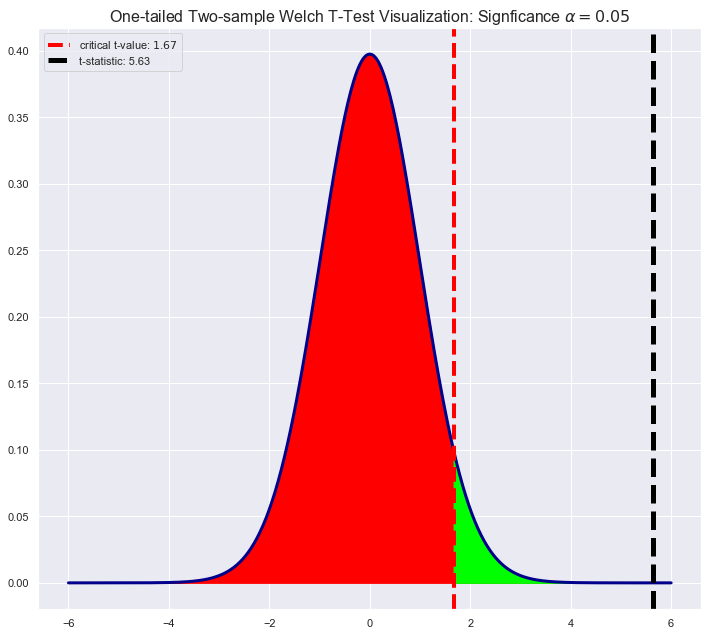

<p><br>

95.0% confidence $\Delta \mu$ is in interval: (0.013, 0.024)

$\mu_1=0.03$ in rejection region $(0.027, 0.033]$: True

$\mu_2=0.012$ in rejection region $[0.009, 0.015)$: True

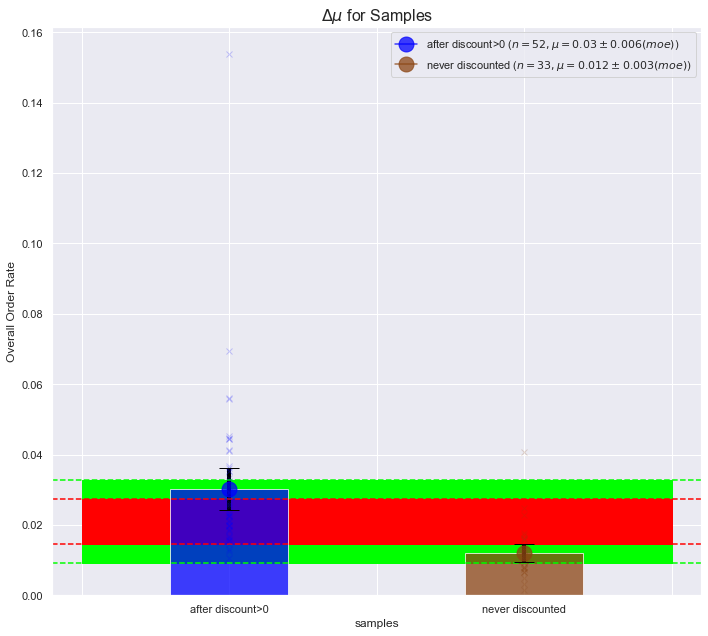

$p\_val\ (1.8921945304294091e-07) < \alpha\ (0.05) \implies$ $\mu_d >\mu$.

In [66]:
mu_d_gt_mu, p_val = t_test_2_samp(
    summed_disc_order_rates_by_customer
    , order_rate_no_disc_df.OrdersPerDayTerm
    , alpha
    , xlabels=['after discount>0','never discounted']
    , ylabel='Overall Order Rate'
    , is_welch=True,
    one_tailed_type='greater'
)
display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override="$\\mu_d " + (">" if mu_d_gt_mu else "\\le") + "\\mu$.")))

This result suggests **discount rate > 0 DOES have a statistically significant effect on INCREASING the average order rate**.

<br>

### Kolmogorov-Smirnov Test

We wish to draw once again on this test to demonstrate these samples are not drawn from the same distributions and also gain an inference in support of the above result.

In [67]:
ks_stat, p_val = stats.ks_2samp(
    summed_disc_order_rates_by_customer
    , order_rate_no_disc_df.OrdersPerDayTerm
)
# h_0: samples are drawn from the same distribution
# h_a: samples are drawn from different distribution

display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override=f"the two samples are drawn from {'different distributions' if p_val < alpha else 'the same distrubution'}.")))

$p\_val\ (1.4544876414390728e-10) < \alpha\ (0.05) \implies$ the two samples are drawn from different distributions.

Let's have a look at the CDFs...

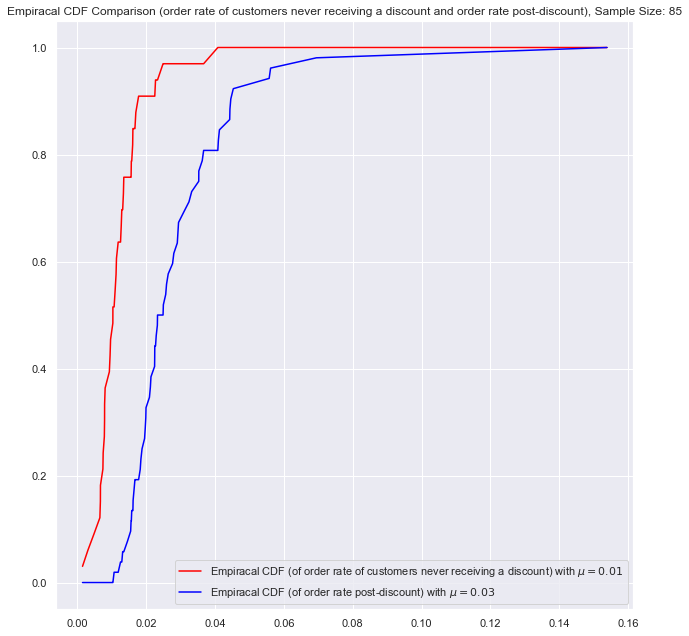

In [68]:
ks_plot_2sample(
    order_rate_no_disc_df.OrdersPerDayTerm
    , summed_disc_order_rates_by_customer
    , ["order rate of customers never receiving a discount", "order rate post-discount"]
)

From the call to `stats.ks_2samp`, as well as the plot above, we see that clearly the distributions are not the same.

Additionally, **for a fixed proportion (probability), we see that that proportion is <u>consistently</u> comprised of a lower OrderRate from orders by customers never receiving a discount vs. post-discount OrderRates of customers that have**.

Let's have a better look at the distributions...

#### Distributions of OrderRate without discount vs. OrderRate post-discount

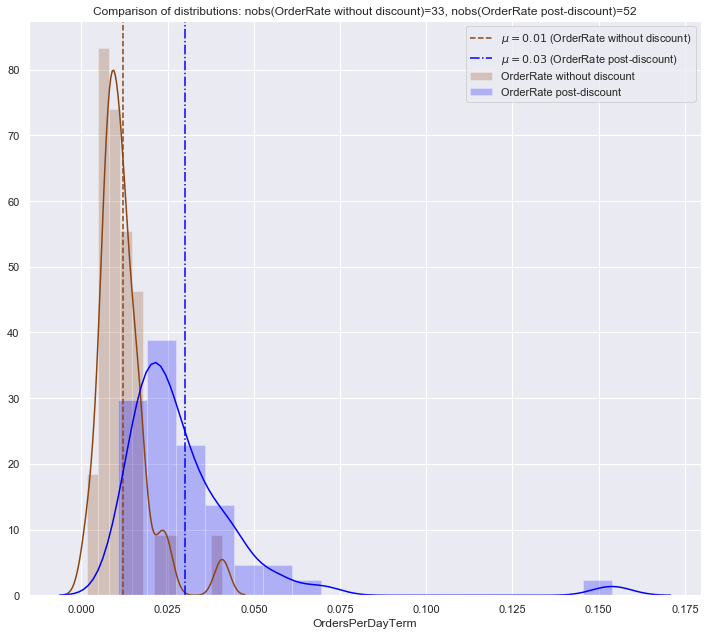

In [69]:
display(Markdown("#### Distributions of OrderRate without discount vs. OrderRate post-discount"))
dist_plot_comparison(
    order_rate_no_disc_df.OrdersPerDayTerm
    , summed_disc_order_rates_by_customer
    , ["OrderRate without discount", "OrderRate post-discount"]
)

This analysis further supports the ***One-tailed Two-Sample Welch Test*** result; i.e. $H_0$ is rejected and $H_a$ is accepted: **discount rate > 0 DOES have a statistically significant effect on increasing the average order rate**.

In [70]:
order_rate_after_discount_factor = mu_d_d/mu
display(Markdown(f"**Customers receiving a discount order roughly {round(order_rate_after_discount_factor,2)} times as often, on average, after receiving a discount.**"))

**Customers receiving a discount order roughly 2.52 times as often, on average, after receiving a discount.**

In the next section, we will investigate whether a particular **Discount** rate induces are higher order rate.

<br><br>

## Answer sub-question 3.a

From the last section, we saw that, indeed, **discount rate > 0 DOES have a statistically significant effect on increasing the average order rate (*which includes subsequent non-discounted orders*)**.

In this section, **we want to determine which discount rate induces a highest post-discount order rate**.  

In effect, we want to compare the mean **OrderRate** values amongst the various **Discount** rates to one another and ask if there is any significant difference.  

We will, for the third time, call on **ANOVA**.

Again recall that **ANOVA (the null hypothesis) assumes there is no difference in means amongst categories.**

The first thing we need to do is construct the data set aggregating **OrderRate** *post-discount*.

Most of the work has already been done above.  We just need to aggregate and group properly.

In [71]:
ord_df = pd.DataFrame(
    {
        'first_discount': disc_grouped_by_customer.first_discount.max()
        , 'OrdersPerDayTermInduced': disc_grouped_by_customer.OrdersPerDayTerm.sum()
    }
)

display(Markdown("#### First few rows of OrderRate Induced Post-Discount"))
scjpnutils.print_df_head(ord_df)

#### First few rows of OrderRate Induced Post-Discount

,first_discount,OrdersPerDayTermInduced
CustomerId,,
ALFKI,0.25,0.035294
AROUT,0.10,0.025000
BERGS,0.10,0.055728
BLONP,0.10,0.019737
BOLID,0.25,0.015504


And now run ***ANOVA***...

In [72]:
f = "OrdersPerDayTermInduced ~ C(first_discount)"
lm = ols(f, ord_df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(first_discount),0.002399,4.0,1.348264,0.266233
Residual,0.020905,47.0,NaN,NaN


So because the p-value $\ge$ 0.05, the results from ***ANOVA* tells us that there is no statistically signficant difference between mean *OrderRate* induced post-discount by varying *Discount* rate > 0**.

At first glance, this suggests there is not much difference in the mean order rate, post-discount.

My first thought is this is likely due to the very small scale we are dealing with.

But let's take a closer look...

In [73]:
def summarize_mean_order_rate_induced_by_discount(ord_df, sort=False):
    display(Markdown("#### Summary of Mean Order-Rate-Induced Post-Discount values grouped by Discount"))
    grouped_by_disc = ord_df.OrdersPerDayTermInduced.groupby(ord_df.first_discount)
    scjpnutils.print_df(grouped_by_disc.describe(), n=None, tail=False, show_count=False)
    
    fig = plt.figure(figsize=fs_default)
    grouped_means = grouped_by_disc.mean().sort_values(ascending=False).reset_index() if sort else grouped_by_disc.mean().reset_index()
    #ax = sns.barplot(x='first_discount', y='OrdersPerDayTermInduced', data=grouped_means)
    ax = sns.barplot(grouped_means.index, grouped_means.OrdersPerDayTermInduced, data=grouped_means)
    ax.set_xticklabels(grouped_means.first_discount)
    plt.ylabel("Mean Induced-Order-Rate")
    plt.xlabel("first_discount")
    for index, row in grouped_means.iterrows():
        ax.text(index, row.OrdersPerDayTermInduced, round(row.OrdersPerDayTermInduced, 3), color='black', ha="center")
    fig.tight_layout()
    plt.show();

#### Summary of Mean Order-Rate-Induced Post-Discount values grouped by Discount

,count,mean,std,min,25%,50%,75%,max
first_discount,,,,,,,,
0.05,10.0,0.024417,0.009359,0.012563,0.019346,0.022872,0.027749,0.045313
0.10,13.0,0.026055,0.012075,0.010695,0.019900,0.022508,0.028037,0.055728
0.15,13.0,0.027484,0.014322,0.016216,0.018484,0.022455,0.030912,0.069444
0.20,7.0,0.032786,0.014303,0.013187,0.024427,0.029046,0.041134,0.056146
0.25,9.0,0.043939,0.042834,0.015504,0.016743,0.035294,0.044335,0.153846


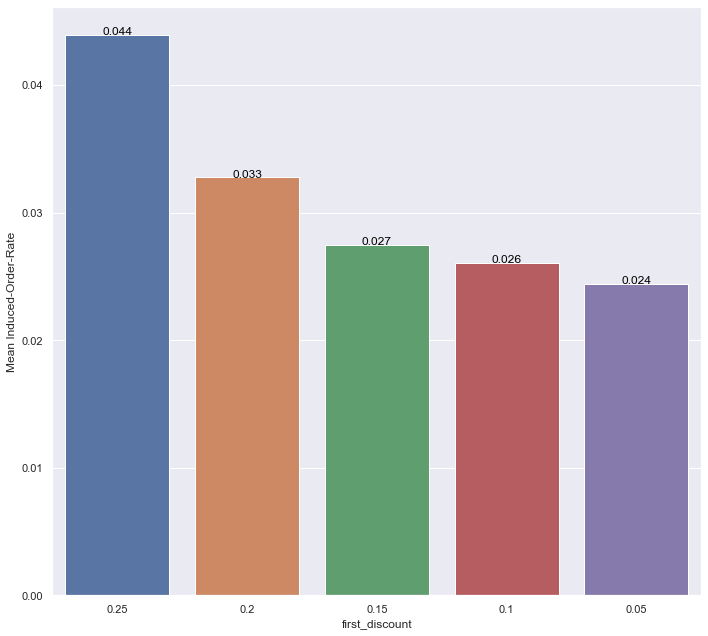

In [74]:
summarize_mean_order_rate_induced_by_discount(ord_df, sort=True)

Very interesting.  

From the summary table and the visualization we see that a 25% discount has a "significantly" different (higher) *post-discount* induced order rate compared to the other discount rates.

**These results seem to disagree with *ANOVA* but do adhere to intuition: *a higher discount rate produces greater results***.  

The trend is obvious in the above plot.

Note that this study does not exclude interim discounted orders, which likely make the effect cumulative.  

But, since results cannot be proven to be statistically reliable, we cannot enforce this claim.

Therefore, **a discount OF ANY KIND ($0.05 \le discount \le 0.25$) seems to induce higher order rates**.

With that, we have concluded this sub-portion of the study.

But, before moving on, let's have a look at the above with non-discounted order rate included.

#### First few rows of ALL OrderRate Induced Post-Discount

,first_discount,OrdersPerDayTermInduced
CustomerId,,
ALFKI,0.25,0.035294
AROUT,0.10,0.025000
BERGS,0.10,0.055728
BLONP,0.10,0.019737
BOLID,0.25,0.015504


#### Summary of Mean Order-Rate-Induced Post-Discount values grouped by Discount

,count,mean,std,min,25%,50%,75%,max
first_discount,,,,,,,,
0.00,33.0,0.011963,0.007251,0.001520,0.007862,0.010345,0.013514,0.040816
0.05,10.0,0.024417,0.009359,0.012563,0.019346,0.022872,0.027749,0.045313
0.10,13.0,0.026055,0.012075,0.010695,0.019900,0.022508,0.028037,0.055728
0.15,13.0,0.027484,0.014322,0.016216,0.018484,0.022455,0.030912,0.069444
0.20,7.0,0.032786,0.014303,0.013187,0.024427,0.029046,0.041134,0.056146
0.25,9.0,0.043939,0.042834,0.015504,0.016743,0.035294,0.044335,0.153846


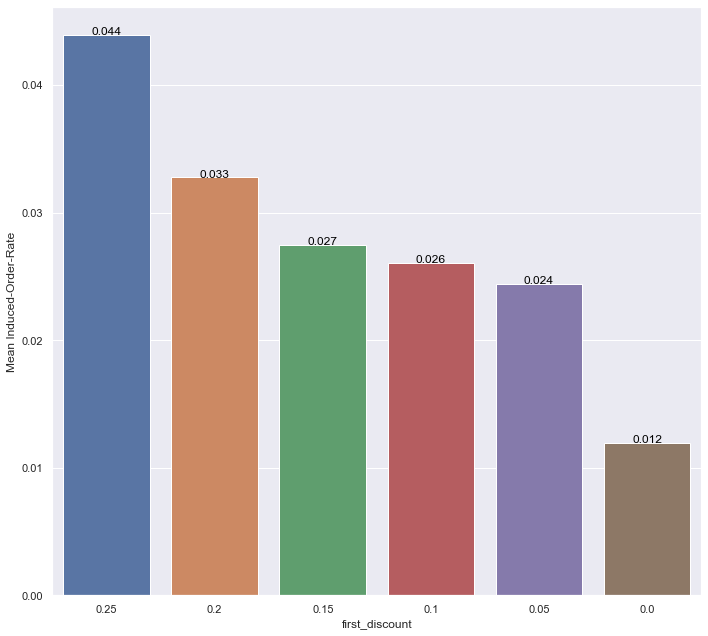

In [75]:
ord_no_disc = pd.DataFrame(
    {
        'first_discount': 0
        , 'OrdersPerDayTermInduced': order_rate_no_disc_df.OrdersPerDayTerm
    }
)
ord_all_df = pd.concat([ord_df, ord_no_disc])

display(Markdown("#### First few rows of ALL OrderRate Induced Post-Discount"))
scjpnutils.print_df_head(ord_all_df)

summarize_mean_order_rate_induced_by_discount(ord_all_df, sort=True)

Including the **OrderRate** of never-discounted customers TOTALLY emphasized the disparity!

Let's move on.

<br><br>

## Answer sub-question 3.b

In this sub-section, we want to answer the question:

    Is the post-discount non-discounted order rate signficantly different (higher) than the order-rate of customers never receiving a discount?
    
That is, ***does a discount induce a higher order rate, EVEN ON SUBSEQUENT NON-DISCOUNTED ORDERS?***

With this question, we will conclude our study on the general worthiness of embarking on a discount campaign for the fictitious Northwind company.

This is a rather straight-forward task but the answer definitely has business value.

<br>

### Compute order rate of non-discounted orders induced post-discount

The only thing that needs to be done here is select only those orders with Discount==0 from the data set produced earlier holding all OrderRate data post-discount, and then compute the mean OrderRate.

In [76]:
non_discounted_after_first_discount_df = pysqldfmgr.pysqldf(f"""
    SELECT DISTINCT
        *
    FROM 
        order_rate_disc_df
    WHERE
        Discount = 0
""")

mu_d = non_discounted_after_first_discount_df.OrdersPerDayTerm.mean()
display(Markdown("#### (First few) Non-Discounted Orders/Day Induced by a Discount"))
scjpnutils.print_df_head(non_discounted_after_first_discount_df)
display(Markdown(f"$\\mu_d={mu_d}$"))

#### (First few) Non-Discounted Orders/Day Induced by a Discount

,CustomerId,Discount,first,last,delta_days,OrderCount,OrdersPerDay,first_discount,first_discount_date,term_date,delta_days_term,OrdersPerDayTerm
0,ALFKI,0.0,2013-10-03,2014-04-09,189.0,5,0.026455,0.25,2013-08-25,2014-05-06,255.0,0.019608
1,AROUT,0.0,2013-06-04,2014-04-10,311.0,7,0.022508,0.10,2013-02-21,2014-05-06,440.0,0.015909
2,BERGS,0.0,2013-06-18,2014-03-04,260.0,9,0.034615,0.10,2013-06-18,2014-05-06,323.0,0.027864
3,BLONP,0.0,2013-02-05,2014-01-12,342.0,6,0.017544,0.10,2013-02-05,2014-05-06,456.0,0.013158
4,BONAP,0.0,2012-11-25,2014-03-11,472.0,9,0.019068,0.05,2012-10-29,2014-05-06,555.0,0.016216


$\mu_d=0.015866159465015277$

<br><br>

### Normality Test

In [77]:
is_normal, p_val = normality_test(order_rate_no_disc_df.OrdersPerDayTerm, alpha, "distribution of OrdersPerDayTerm values for orders without discounts")
print(f"len(order_rate_no_disc_df.OrdersPerDayTerm)={len(order_rate_no_disc_df.OrdersPerDayTerm)}")
is_normal, p_val_d = normality_test(non_discounted_after_first_discount_df.OrdersPerDayTerm, alpha, "distribution of non-discounted OrdersPerDayTerm values after first discount")
print(f"len(non_discounted_after_first_discount_df.OrdersPerDayTerm)={len(non_discounted_after_first_discount_df.OrdersPerDayTerm)}")

$p\_val\ (2.715390563126579e-07) < \alpha\ (0.05) \implies$ distribution of OrdersPerDayTerm values for orders without discounts is NOT normal

len(order_rate_no_disc_df.OrdersPerDayTerm)=33


$p\_val\ (7.389014352029445e-14) < \alpha\ (0.05) \implies$ distribution of non-discounted OrdersPerDayTerm values after first discount is NOT normal

len(non_discounted_after_first_discount_df.OrdersPerDayTerm)=50


<br>

### Equal-variance Test

In [78]:
v_no_discount = np.var(order_rate_no_disc_df.OrdersPerDayTerm)
print(f"OrdersPerDayTerm of orders without a discount has variance: {v_no_discount}.")
v_discounted = np.var(non_discounted_after_first_discount_df.OrdersPerDayTerm)
print(f"non-discounted OrdersPerDayTerm of orders after first discount has variance: {v_discounted}.")

equal_var, p_val = equal_variance_test(order_rate_no_disc_df.OrdersPerDayTerm, non_discounted_after_first_discount_df.OrdersPerDayTerm, alpha)

OrdersPerDayTerm of orders without a discount has variance: 5.0980612933341814e-05.
non-discounted OrdersPerDayTerm of orders after first discount has variance: 0.00013419212345315007.


$p\_val\ (0.2252179914241944) \ge \alpha\ (0.05) \implies$ samples ARE from populations with equal variances

<br>

Therefore, even though the equal-variance test passes, we opt to use the ***One-tailed Two-sample Welch T-Test*** since the samples are of unequal size.

<br>

### One-tailed Two-sample Welch T-Test
Recall:

$H_0$: $\mu_d \le \mu$.

$H_a$: $\mu_d > \mu$.

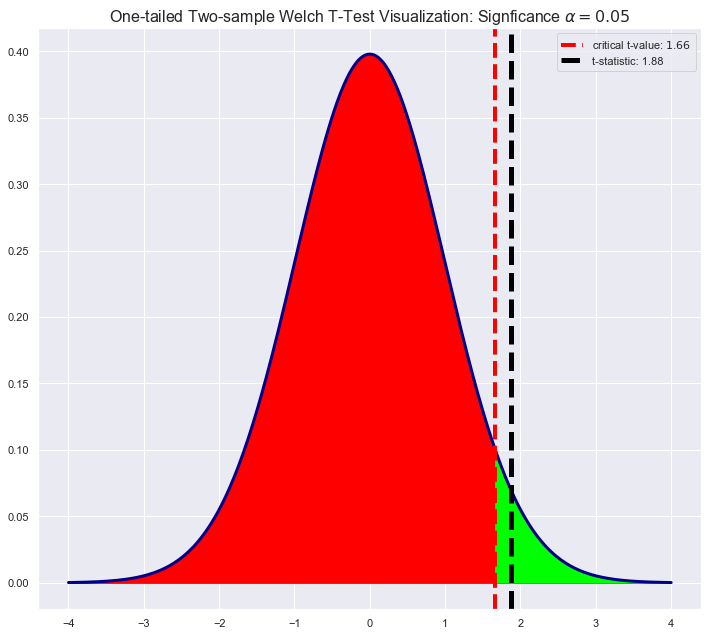

<p><br>

95.0% confidence $\Delta \mu$ is in interval: (0.001, 0.007)

$\mu_1=0.016$ in rejection region $(0.015, 0.017]$: True

$\mu_2=0.012$ in rejection region $[0.011, 0.013)$: True

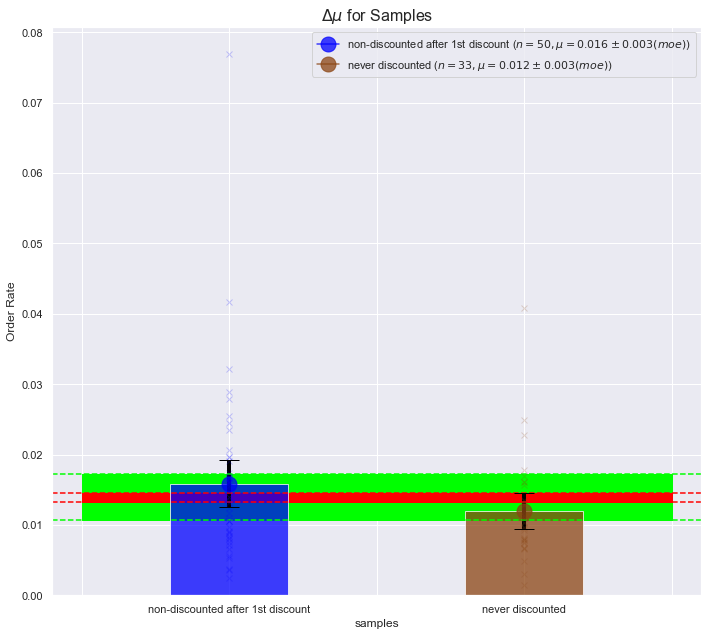

$p\_val\ (0.03217935778439411) < \alpha\ (0.05) \implies$ $\mu_d >\mu$.

In [79]:
mu_d_gt_mu, p_val = t_test_2_samp(
    non_discounted_after_first_discount_df.OrdersPerDayTerm
    , order_rate_no_disc_df.OrdersPerDayTerm
    , alpha
    , xlabels=['non-discounted after 1st discount','never discounted']
    , ylabel='Order Rate'
    , is_welch=True,
    one_tailed_type='greater'
)
display(Markdown(format_pval_result(p_val, alpha, kwargs=None, s_override="$\\mu_d " + (">" if mu_d_gt_mu else "\\le") + "\\mu$.")))

This result suggests **discount rate > 0 DOES have a statistically significant effect on INCREASING the average order rate of non-discounted orders after receiving a discount of any kind**.

<br>

### Kolmogorov-Smirnov Test

We wish to draw once again on this test to demonstrate these samples are not drawn from the same distributions and also gain an inference in support of the above result.

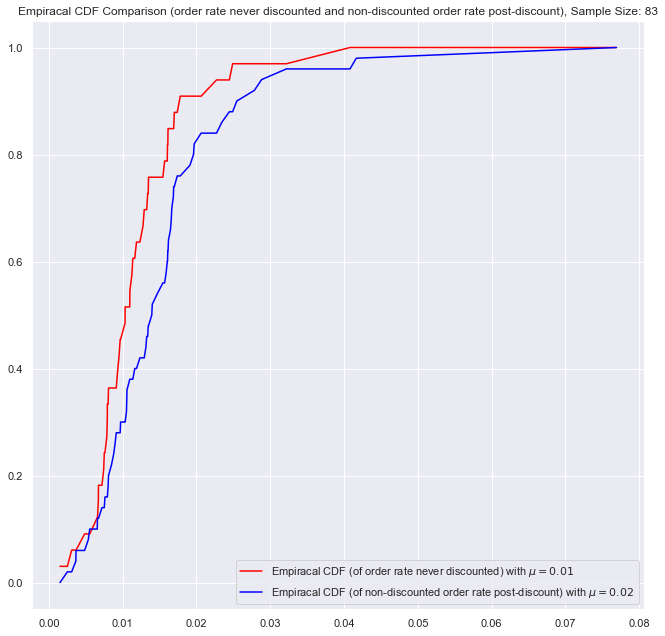

#### Distributions of OrderRate never discounted vs. Non-discounted OrderRate post-discount

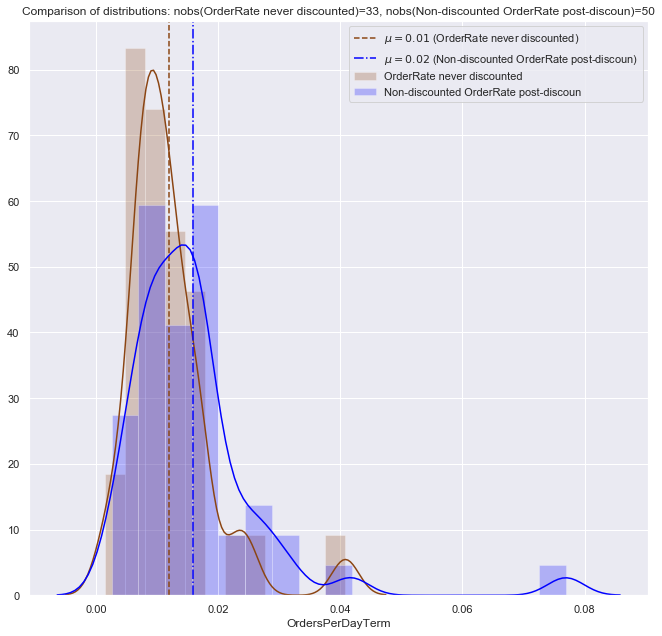

In [80]:
ks_plot_2sample(
    order_rate_no_disc_df.OrdersPerDayTerm
    , non_discounted_after_first_discount_df.OrdersPerDayTerm
    , ["order rate never discounted", "non-discounted order rate post-discount"]
)

display(Markdown("#### Distributions of OrderRate never discounted vs. Non-discounted OrderRate post-discount"))
dist_plot_comparison(
    order_rate_no_disc_df.OrdersPerDayTerm
    , non_discounted_after_first_discount_df.OrdersPerDayTerm
    , ["OrderRate never discounted", "Non-discounted OrderRate post-discoun"]
)

This analysis further supports the ***One-tailed T-Test*** result; i.e. $H_0$ is rejected and $H_a$ is accepted: **discount rate > 0 DOES have a statistically significant effect on INCREASING the average order rate of non-discounted orders after receiving a discount of any kind**.

In [81]:
non_discounted_order_rate_after_discount_factor = mu_d/mu
display(Markdown(f"**Customers place NON-DISCOUNTED orders roughly {round(non_discounted_order_rate_after_discount_factor,2)} times as often (than customers never receiving a discount), on average, after receiving a discount.**"))

**Customers place NON-DISCOUNTED orders roughly 1.33 times as often (than customers never receiving a discount), on average, after receiving a discount.**

## SUMMARY:

**Offering a discount does indeed have a statistically significant effect on increasing the average order rate of subsequent orders, EVEN ON SUBSEQUENT NON-DISCOUNTED ORDERS.**

Since **discounting an order promotes an increased order rate in the future, revenue gains may be realized longer-term and looks to have an impact on customer retention as a function of term order-rate**.

**In general, customers receiving a discount order roughly 2.52 times as often, on average, after receiving a discount**.  This translates to a 252% overall term-probability to order again after the first discount, compared to customers never discounted.

**For non-discounted orders following a discount, customers STILL place NON-DISCOUNTED orders roughly 1.33 times as often as customers never discounted**.  This translates to a 133% term-probability to order again WITHOUT A DISCOUNT after the first discount, compared to customers never discounted.  

### RECOMMENDATION:
Evidence suggests that implementing a discount campaign has an apparent lasting effect on customers' subsequent order rate and therefore makes a strong business case to **DO IT!**

### FUTURE WORK:
1. Create visualizations of the associated (time-series) Poisson Distributions and compute probability that a customer will order again within some timeframe given that the customer received a discount on a prior order.
2. Investigate scaling factor to flush out inconsistency between ANOVA and visualization (and basic summary statistics) for Induced Post-Discount Order-Rate.
3. Investigate if there is a significant relationship between **OrderRate** and **CustomerDemographic** in order to devise an ad campaign to further revenue gains.
4. Investigate if there is a significant relationship between **OrderSubtotal** (revenue) and **ShippingRate** to flush out whether an in-house shipping fleet vs. third-party shipping is a worthy investment.

<br><br>

## References

Mason, H., & Wiggins, C. Data Science Process [Image]. Retrieved from https://miro.medium.com/max/3870/1*eE8DP4biqtaIK3aIy1S2zA.png

MC.test: Monte Carlo hypothesis testing for two samples. in asbio: A Collection of Statistical Tools for Biologists. (2020). Retrieved from https://rdrr.io/cran/asbio/man/MC.test.html

Analysis of Variance (ANOVA). (2019). Retrieved from https://pythonfordatascience.org/anova-python/

Héroux, M. (2017). Independent t-test in Python. Retrieved from https://scientificallysound.org/2017/05/16/independent-t-test-python/

Prabhakaran, S. (2019). Time Series Analysis in Python - A Comprehensive Guide with Examples - ML+. Retrieved from https://www.machinelearningplus.com/time-series/time-series-analysis-python/

Admin. (2018). Introduction to Confidence Intervals - Statology. Retrieved from https://www.statology.org/introduction-to-confidence-intervals/